In [1]:
'''
Authors: Daniel M. Low
License: Apache 2.0

'''

import os
import re
import sys
import json
from collections import Counter
from pprint import pprint
import requests
import time
from datetime import datetime, date, timedelta
import string
import math
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
import plotly.express as px
from plotly import graph_objs as go
from sklearn import preprocessing
from statsmodels.stats.multitest import multipletests
from scipy.interpolate import make_interp_spline, BSpline
from scipy.stats import spearmanr


/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/google/colab/data_table.py:30: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



# Set paths

In [3]:
# Google Colab path
# Run this cell to be able to mount GDrive and attach it to the colab so that we can save json outputs
# from google.colab import drive
# drive.mount('/content/drive')
# input_dir = './drive/My Drive/ML4HC_Final_Project/data/input/'
# output_dir = './drive/My Drive/ML4HC_Final_Project/data/output/'

# # # My local path
# input_dir = './../../datum/reddit/input/'
# output_dir = './../../datum/reddit/output/'

# Open Science Framework path
input_dir = './data/input/'
output_dir = './data/output/'


import plotly.express as px
import plotly.graph_objs as go
import chart_studio.plotly as py

In [5]:
def histogram(y):
    sns.set(style='white', rc={'figure.figsize':(10,8)}, palette = "coolwarm", font_scale =1)
    labels, values = zip(*Counter(y).items())
    labels, values  = zip(*sorted(zip(labels, values )))
    labels = [int(n) for n in labels]


    indexes = np.arange(len(labels))
    width = 1

    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels, rotation=90)
    plt.show()
    return


In [6]:
# input y variable across time


def plot_across_time(subreddits, x = None, y_col = '', y_col_div_by = '', zscore=False, ylabel='Average negative sentiments',filter_small = True, small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.3, plot_covid_curves = False):
    '''
    y_col: {'all_words', ''}
    y_col_div_by: {'total_posts'}
    small_vale = if you want to include small posts, set to 0. 150 shizophrenia
    '''
    sns.set(style='white', rc={'figure.figsize':(10,8)}, font_scale =1.5)
    cmap = cm.Set3 # tab20c Set3
    cmap = cm.jet(np.linspace(0,1,len(subreddits)+1))
        
    # Load each rubreddit 
    for i,subreddit in enumerate(subreddits):

        df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
        # Some just have avg 10 posts per time segment, so not worth plotting        
        total_posts = df_subreddit[['subreddit', 'date']].groupby(['date']).agg(['count']).values
        if np.mean(total_posts)  < small_value:
            continue
        # Load y
        if y_col == 'total_posts':
            y = total_posts.copy()
        else:
            y = df_subreddit[[y_col, 'date']].groupby(['date']).agg(['sum']).values
        if y_col_div_by == 'total_posts':
            y = y/total_posts
        
        y = [n[0] for n in y]
        if zscore:
            if len(np.unique(y)) == 1:
                # By mistake I downloaded every 3 days and some subreddits max at 1000, so zscore of same values (1000,1000,..., 1000) is not possible                 
                continue
            else:
                y = stats.zscore(y)

        # Load x, is the same for all         
        if x == None:
            x = list(set(df_subreddit['date'].values))
            try: x.remove(np.nan)
            except: pass
            x.sort()
        x_num =range(len(x))  
        if plot_raw:
            plt.plot(x,y, alpha=alpha,color=cmap[i])
        if plot_line:
            m, b = np.polyfit(x_num, y, 1)
            plt.plot(x, m*x_num + b, color=cmap[i], alpha=1,label='r/'+subreddit)
        else:
            plt.plot(x,y, alpha=1,color=cmap[i],label='r/'+subreddit)
    
    plt.xticks(ticks=range(len(list(x))), labels=list(x),rotation=90)
    
    # Plot covid confirmed cases 
    if plot_covid_curves:
        for y_country, country,color in zip(y_countries, countries, ['k','gray','darkgray']):
            plt.plot(x,y_country, alpha=1,color=color, label='Confirmed cases - {}'.format(country))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if zscore:
        ylabel += ' (z-score)'
    plt.ylabel(ylabel)
    return



    

In [7]:

def boxplot_across_time(subreddit, x = None, y_col = '', y_col_div_by = '', zscore=False, ylabel='Average negative sentiments',filter_small = True, small_value = 150, plot_raw = True, 
                     plot_line = True, alpha = 0.3, plot_covid_curves = False):
    '''
    y_col: {'all_words', ''}
    y_col_div_by: {'total_posts'}
    small_vale = if you want to include small posts, set to 0. 150 shizophrenia
    '''
    sns.set(style='white', rc={'figure.figsize':(10,8)}, font_scale =1.5)
    cmap = cm.Set3 # tab20c Set3
    cmap = cm.jet(np.linspace(0,1,len(subreddits)+1))
        
    # Load each rubreddit 
    for i,subreddit in enumerate(subreddits):

        df_subreddit = pd.read_csv(output_dir+'features_{}_0.csv'.format(subreddit))
        # Some just have avg 10 posts per time segment, so not worth plotting        
        total_posts = df_subreddit[['subreddit', 'date']].groupby(['date']).agg(['count']).values
        if np.mean(total_posts)  < small_value:
            continue
        # Load y
        y = df_subreddit[[y_col, 'date']].groupby(['date']).agg(['sum']).values
        if y_col_div_by == 'total_posts':
            y = y/total_posts
        
        y = [n[0] for n in y]
        if zscore:
            if len(np.unique(y)) == 1:
                # By mistake I downloaded every 3 days and some subreddits max at 1000, so zscore of same values (1000,1000,..., 1000) is not possible                 
                continue
            else:
                y = stats.zscore(y)

        # Load x, is the same for all         
        if x == None:
            x = list(set(df_subreddit['date'].values))
        x_num =range(len(x))  
        if plot_raw:
            plt.plot(x,y, alpha=alpha,color=cmap[i])
        if plot_line:
            m, b = np.polyfit(x_num, y, 1)
            plt.plot(x, m*x_num + b, color=cmap[i], alpha=1,label='r/'+subreddit)
        else:
            plt.plot(x,y, alpha=1,color=cmap[i],label='r/'+subreddit)
    
    plt.xticks(ticks=range(len(list(x))), labels=list(x),rotation=90)
    
    # Plot covid confirmed cases 
    if plot_covid_curves:
        for y_country, country,color in zip(y_countries, countries, ['k','gray','darkgray']):
            plt.plot(x,y_country, alpha=1,color=color, label='Confirmed cases - {}'.format(country))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if zscore:
        ylabel += ' (z-score)'
    plt.ylabel(ylabel)
    return



    

In [8]:
def timeseries_summary(input_dir, subreddit = 'personalfinance', pre_or_post = 'post', 
                       timestep = 2, metric='mean',weigh_by_Nwords = True,filter_days = False, apply_zscore=True, zscore_slope = True):
    # Merge different types of features     
    if 'covid19_counts' in input_dir:
        feature_type = 'covid19_counts'
    elif 'reddit_mental_health_dataset' in input_dir:
        feature_type = 'tfidf_256'
        
    df = pd.read_csv(input_dir+f'{subreddit}_{pre_or_post}_features_{feature_type}.csv') #index_col = 0 depends on dataset.
    features = list(df.columns)
    features = [n for n in features if n not in ['subreddit','author','date','post']]
    
    # Weigh value by amount of words in posts (if not amount of words will confound patterns in other variables)     
    if weigh_by_Nwords:
        # weight these variables by n_words
        weigh = features.copy()
        [weigh.remove(n) for n in ['n_chars', 'n_sents', 'n_words','sent_neg', 'sent_neu', 'sent_pos','sent_compound', 'automated_readability_index', 'coleman_liau_index',
               'flesch_kincaid_grade_level', 'flesch_reading_ease', 'gulpease_index',
               'lix', 'wiener_sachtextformel', 'gunning_fog_index', 'smog_index']]
        df[weigh] = df[weigh].div(df['n_words'].values, axis=0)



    # Group value by timestep     
    days = np.unique(df.date)
    if filter_days:
        for day in filter_days:
            days = [n for n in days if day not in n]
            
    days_timestep = days[::timestep]
    X = []
    y = []
    for i in range(0,len(days),timestep):
        days_week = days[i:i+timestep]
        df_week = df[df.date.isin(days_week)]
        df_week_feature_cols = df_week[features].values
        df_week_y = list(df_week.subreddit)
        X.append(df_week_feature_cols)
        y.append(df_week_y)

    X = np.array(X)
    y = np.array(y)
    
    # Take summary stat metric by timestep     
    summary = []
    for timestep in X:
        n_posts = timestep.shape[0] 
        if metric == 'mean':
            # sum will depend on subreddit size, so can only be used if subreddits are balanced.              
            summary_timestep = list(timestep.mean(axis=0))

        timestep_df = pd.DataFrame(timestep, columns=features)
        summary_timestep.append(n_posts)
        summary.append(summary_timestep)

    summary = pd.DataFrame(summary)
    
    if apply_zscore:
        summary = summary.apply(zscore)
    summary = summary.T
    summary.columns = days_timestep
    summary.index = features+['n_posts']

    # add slope and p-value
    slopes = []
    p_values = []
    significances = []
    r2 = []
    for feature in features+['n_posts']:
        slope, intercept, r_value, p_value, std_err = stats.linregress(range(len(summary.T.index)), summary.T[feature])
        slopes.append(slope)
        p_values.append(p_value)
        r2.append(r_value**2)
        alpha = 0.05     # corrected_alpha = 0.05/len(features)
        if p_value <= alpha:
            significances.append(1)
        else:
            significances.append(-1)
    
    if zscore_slope:
        summary['slope'] = stats.zscore(slopes)
        summary['p_value'] = stats.zscore(p_values)
        summary['sign'] = stats.zscore(significances)
        summary['r2'] = stats.zscore(r2)
    else:
        summary['slope'] = slopes
        summary['p_value'] = p_values
        summary['sign'] = significances
        summary['r2'] = r2
        
    return summary
    

## Define subreddits 

In [9]:
#     reordered by related subreddits
subreddits = [
     'COVID19_support',
'mentalhealth',
    'anxiety',
     'socialanxiety',
     'healthanxiety',
         'autism',
 'adhd',  
     'ptsd',
     'lonely',
     'depression',
 'suicidewatch',    
     'bipolarreddit',
     'bpd',
     'schizophrenia',
    'addiction',
     'alcoholism',
 'EDAnonymous',
 'personalfinance',
     'conspiracy',
     'guns',
 'legaladvice',    
    'divorce',
 'relationships',
    'parenting',
    'teaching',
 'meditation',
 'fitness',
 'jokes'
]

subreddits_mental_health = [
     'anxiety',
     'socialanxiety',
     'healthanxiety',
         'autism',
 'adhd',  
     'ptsd',
     'lonely',
     'depression',
 'suicidewatch',    
     'bipolarreddit',
     'bpd',
    'addiction',
     'alcoholism',
 'EDAnonymous',
 'schizophrenia']
    

In [14]:
# Filter features
keep = [
    'n_posts', 'n_words',     'n_chars', 'punctuation',  'n_sents', 
    #     word_type
    'n_unique_words', 'n_long_words',        'n_syllables',   'n_monosyllable_words', 'n_polysyllable_words', 
    
#     functionals    
    'liwc_total_functional', 'liwc_impersonal_pronouns', 'liwc_total_pronouns', 'liwc_personal_pronouns',
'liwc_1st_pers', 'liwc_2nd_pers', 'liwc_3rd_pers', 
       'liwc_articles_article', 
#     POS
    'liwc_common_verbs',
       'liwc_auxiliary_verbs', 'liwc_past_tense', 'liwc_present_tense', 'liwc_future_tense',
       'liwc_adverbs', 'liwc_prepositions', 'liwc_conjunctions', 'liwc_negations',    'liwc_assent',
       'liwc_quantifiers', 'liwc_numbers', 
    'liwc_nonfluencies', 'liwc_fillers',
    
#     readability
    'flesch_kincaid_grade_level', 'lix',
'automated_readability_index',
       'coleman_liau_index',
       'flesch_reading_ease', 'gulpease_index', 'gunning_fog_index',
       'smog_index', 'wiener_sachtextformel',     

#    Sentiment 
    'sent_neg', 'sent_neu', 'sent_pos',
       'sent_compound', 
    'liwc_affective_processes',
       'liwc_positive_emotion', 'liwc_negative_emotion', 'liwc_anxiety', 'liwc_anger','liwc_swear_words', 
       'liwc_sadness',
# Existential / death    
    'liwc_religion', 
    'liwc_death', 'guns_total','substance_use_total', 'suicidality_total',
# Cognitive    
    'liwc_cognitive', 'liwc_insight', 'liwc_causation', 'liwc_discrepancy',
       'liwc_tentative', 'liwc_certainty', 'liwc_inhibition', 'liwc_inclusive', 'liwc_exclusive',
       'liwc_perceptual_processes', 'liwc_see', 'liwc_hear', 'liwc_feel', 
# Biological
    'liwc_biological',
'liwc_ingestion', 'liwc_relativity', 'liwc_motion','liwc_body', 'liwc_health', 'liwc_sexual', 
    # Work, economic stress, leisure
    'liwc_work',     'liwc_leisure',  'economic_stress_total', 'liwc_money','liwc_time','liwc_achievement',
    # Social and home and isolation
    'liwc_social_processes','liwc_home',         
    'domestic_stress_total','liwc_space',    
       'liwc_family', 'liwc_friends', 'liwc_humans', 'isolation_total',
    
]



# 1. Count unique users per dataset

In [16]:

total_all_timewindows = []
timesteps = ['post', 'pre', '2019','2018', ]
for timestep in timesteps:
# for timestep in ['pre']:
    print(timestep)
    total = []
    for sr in subreddits:
        try:
            df = pd.read_csv(input_dir+f'reddit_mental_health_dataset/{sr}_{timestep}_features_tfidf_256.csv')
            print(sr)
            total.append(np.unique(df.author.values))
        except:
            pass
    total_all_timewindows.append(total)
    

post
COVID19_support
mentalhealth
anxiety
socialanxiety
healthanxiety
autism
adhd
ptsd
lonely
depression
suicidewatch
bipolarreddit
bpd
schizophrenia
addiction
alcoholism
EDAnonymous
personalfinance
conspiracy
guns
legaladvice
divorce
relationships
parenting
teaching
meditation
fitness
jokes
pre
mentalhealth
anxiety
socialanxiety
healthanxiety
autism
adhd
ptsd
lonely
depression
suicidewatch
bipolarreddit
bpd
schizophrenia
addiction
alcoholism
EDAnonymous
personalfinance
conspiracy
guns
legaladvice
divorce
relationships
parenting
teaching
meditation
fitness
jokes
2019
mentalhealth
anxiety
socialanxiety
healthanxiety
autism
adhd
ptsd
lonely
depression
suicidewatch
bipolarreddit
bpd
schizophrenia
addiction
alcoholism
EDAnonymous
personalfinance
conspiracy
guns
legaladvice
divorce
relationships
parenting
teaching
meditation
fitness
jokes
2018
mentalhealth
anxiety
socialanxiety
healthanxiety
autism
adhd
ptsd
lonely
depression
suicidewatch
bipolarreddit
bpd
schizophrenia
addiction
alcoholism

In [26]:
total_all_timewindows_flat = []
for window, timestep in zip(total_all_timewindows, timesteps):
    window = [n for i in window for n in i]
    total_all_timewindows_flat.append(window)
    print(timestep, len(window))

    


post 320364
pre 327289
2019 282560
2018 177089


In [27]:
total_all_timewindows_flat = [n for i in total_all_timewindows_flat for n in i]
print(len(total_all_timewindows_flat))
print(len(np.unique(total_all_timewindows_flat)))

1107302
826961


In [222]:
# total
print('total: ',len(total2))
print('total: ',len(set(total2)))

total:  1107302
total:  826961


# 2. How many times is COVID19 mentioned and when?


### Find covid19 related words: tried with TFIDF, didn't work well and then used a glossary I found online

In [10]:
# # What are the top terms in COVID19_support 
# from sklearn.feature_extraction.text import TfidfVectorizer

# subreddit = 'COVID19_support'
# docs_covid = pd.read_csv(input_dir+'docs_covid19.csv', index_col=0)
# docs_rest = pd.read_csv(input_dir+'docs_pre_all_subreddits.csv',index_col=0)['docs_train'].values

# docs_covid = np.array([n for i in docs_covid.values for n in i])
# # docs_rest = np.array([n for i in docs_rest.values for n in i])

# Find top tfidf words for covid19_support: didn´t work as well as online glossary (see below)
# from nltk import PorterStemmer
# import re
# def stemming_tokenizer(str_input):

# 	'''
# 	http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/counting-and-stemming/

# 	:param str_input:
# 	:return:
# 	'''
# 	porter_stemmer = PorterStemmer()
# 	words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
# 	words = [porter_stemmer.stem(word) for word in words]
# 	return words


# tfidf = TfidfVectorizer(tokenizer=stemming_tokenizer, ngram_range=(1,2), stop_words='english',max_features=512, min_df=2, max_df=0.8)
# tfidf.fit_transform(docs_rest)
# target = tfidf.transform(docs_covid)
# feature_array = np.array(tfidf.get_feature_names())
# tfidf_sorting = np.argsort(target.toarray()).flatten()[::-1]

# # List top terms for covid19
# n = 1000
# top_n = feature_array[tfidf_sorting][:n]
# print(top_n)

# from collections import Counter
# counter = Counter(docs_covid_str.split(' '))
# counter.most_common()

In [13]:
# After not getting very informative results with tfidf I end up using this: https://www.tmc.edu/news/2020/05/covid-19-crisis-catalog-a-glossary-of-terms/
# Count number times a specific phrase appears in the text.
def count_words(doc,phrases=[]):
    # remove punctuation except apostrophes because we need to search for things like "don't want to live"
    text = re.sub("[^\w\d'\s]+",'',doc.lower())
    counter = 0
    for phrase in phrases:
        counter += text.count(phrase)
    return counter


# Words should not be frequent in mental health subreddits outside of pandemic. didnt include flu, because it's in "influence", etc.
words = ['corona','virus','viral','covid', 'sars','influenza','pandemic', 'epidemic', 
         'quarantine','lockdown', 'distancing', 'national emergency', 'flatten', 
             'infect','ventilator', 'mask','symptomatic',
            'epidemiolog', 'immun', 'incubation', 'transmission','vaccine', ]


pre_or_post = 'post'

# Save feature extraction
save_files = False #False so it won't run on accident
if save_files:
for subreddit in subreddits:
    df = pd.read_csv(input_dir+'reddit_mental_health_dataset/{}_{}_features_tfidf_256.csv'.format(subreddit,pre_or_post))    
    posts = df.post.values
    counts_covid = [count_words(post,phrases=words) for post in posts]
    df_new = df[['subreddit','date', 'post', 'n_words']]
    df_new['covid19_boolean'] = [n/n if n>0 else n for n in counts_covid]
    df_new['covid19_total'] = counts_covid
    df_new['covid19_weighed_words'] = counts_covid
    df_new['covid19_weighed_words'] = df_new['covid19_weighed_words'].div(df_new['n_words'].values, axis=0)
    df_new.to_csv(input_dir+'/covid19_counts/{}_{}_features_covid19_counts.csv'.format(subreddit,pre_or_post))
    
    



## Plot Figure 1 and S3

In [91]:
# Set path
input_dir_covid_counts = input_dir+'covid19_counts/'


summary =  timeseries_summary(input_dir_covid_counts, subreddit = 'addiction', pre_or_post = 'post', 
                           timestep = 2, metric='mean',weigh_by_Nwords = False,filter_days = False, apply_zscore=False, zscore_slope = False)
    
x_name = summary.columns[:-4].values
    
# Load confirmed COVID19 cases from Our World in Data dataset
total_cases = pd.read_csv(input_dir+'covid19_total_cases.csv')
# Select only these days
days = [n.replace('/', '-') for n in x_name]
total_cases = total_cases[total_cases.date.isin(days)]
usa = total_cases['United States'].values
world = total_cases['World'].values
china = total_cases['China'].values

In [92]:
usa = [int(str(n).replace('0','1')) for n in usa]
china = [int(str(n).replace('0','1')) for n in china]
world = [int(str(n).replace('0','1')) for n in world]


In [11]:
subreddits_mental_health_sorted = subreddits_mental_health.copy()
subreddits_mental_health_sorted.sort()
subreddits_mental_health_sorted.remove('EDAnonymous') # change order so the colors are better distributed
subreddits_mental_health_sorted.insert(8, 'EDAnonymous')
subreddits_mental_health_sorted.remove('alcoholism') #so the colors are better distributed
subreddits_mental_health_sorted.insert(0, 'alcoholism')
subreddits_mental_health_sorted.remove('anxiety') #so the colors are better distributed
subreddits_mental_health_sorted.insert(2, 'anxiety')
subreddits_mental_health_sorted

['alcoholism',
 'addiction',
 'anxiety',
 'adhd',
 'autism',
 'bipolarreddit',
 'bpd',
 'depression',
 'EDAnonymous',
 'healthanxiety',
 'lonely',
 'ptsd',
 'schizophrenia',
 'socialanxiety',
 'suicidewatch']

alcoholism
=====covid19_boolean====
addiction
=====covid19_boolean====
anxiety
=====covid19_boolean====
adhd
=====covid19_boolean====
autism
=====covid19_boolean====
bipolarreddit
=====covid19_boolean====
bpd
=====covid19_boolean====
depression
=====covid19_boolean====
EDAnonymous
=====covid19_boolean====
healthanxiety
=====covid19_boolean====
lonely
=====covid19_boolean====
ptsd
=====covid19_boolean====
schizophrenia
=====covid19_boolean====
socialanxiety
=====covid19_boolean====
suicidewatch
=====covid19_boolean====


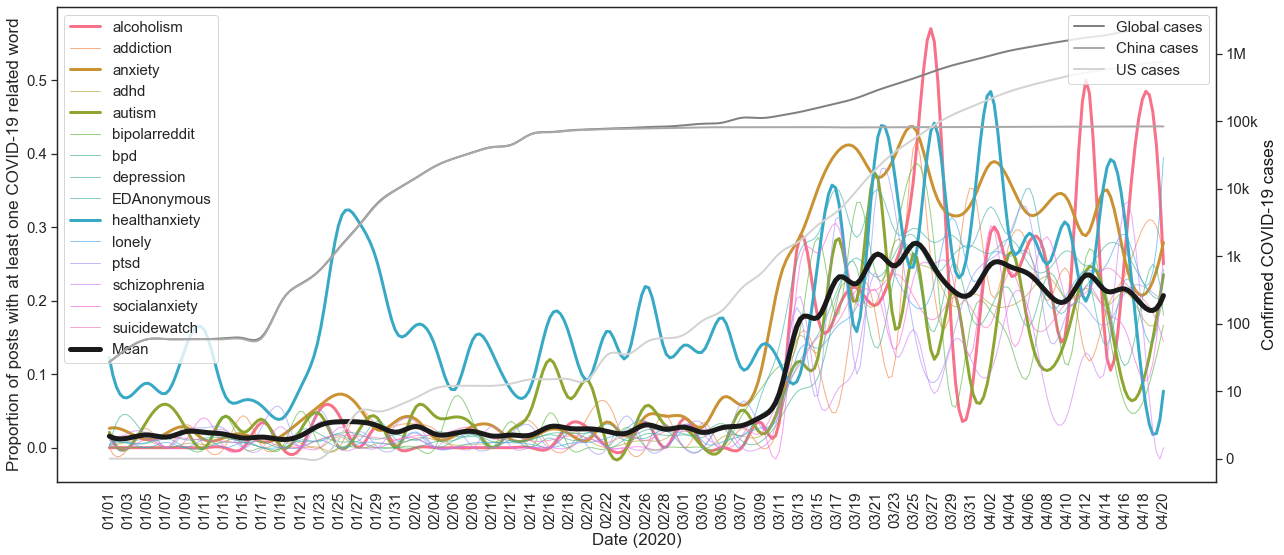

correlation between mean and global covid cases
Is zero lag best?: True
cross-correlation between mean and global cases (lag): 29.61 (0 days)
highest: 29.61 (doing full)
value in the middle: 29.61 (middle value)
jsut doing method valid: 29.61 (doing valid, should be the same)
Spearman (on zero lag):
rho (p-value) = 0.83 (1.9588571499920974e-15)
alcoholism
=====covid19_weighed_words====
addiction
=====covid19_weighed_words====
anxiety
=====covid19_weighed_words====
adhd
=====covid19_weighed_words====
autism
=====covid19_weighed_words====
bipolarreddit
=====covid19_weighed_words====
bpd
=====covid19_weighed_words====
depression
=====covid19_weighed_words====
EDAnonymous
=====covid19_weighed_words====
healthanxiety
=====covid19_weighed_words====
lonely
=====covid19_weighed_words====
ptsd
=====covid19_weighed_words====
schizophrenia
=====covid19_weighed_words====
socialanxiety
=====covid19_weighed_words====
suicidewatch
=====covid19_weighed_words====


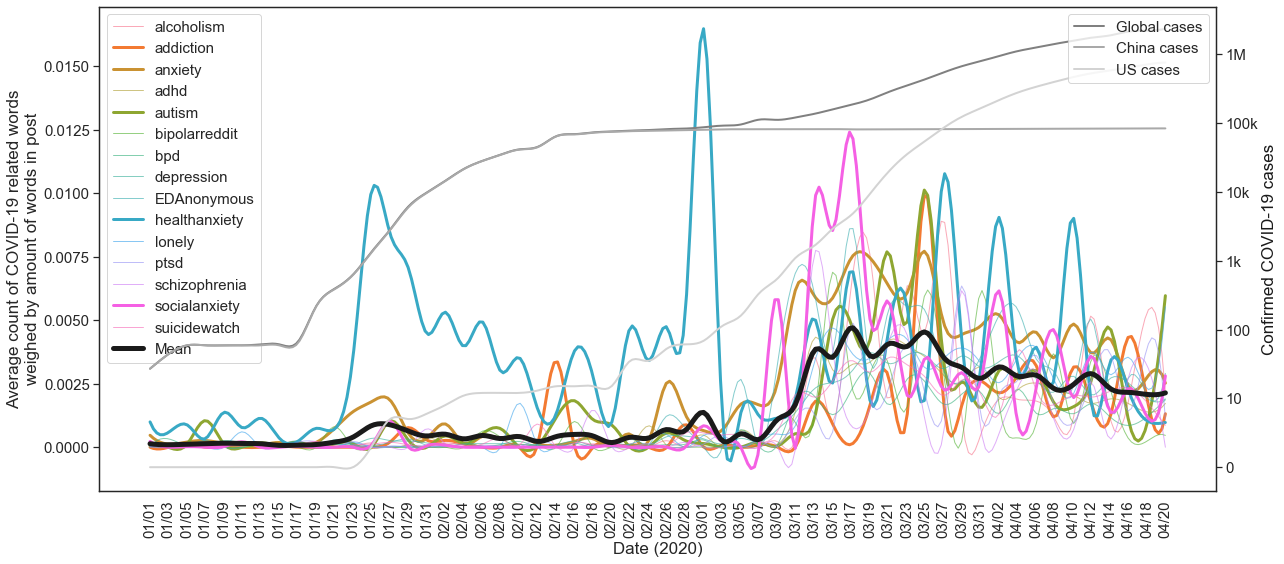

correlation between mean and global covid cases
Is zero lag best?: True
cross-correlation between mean and global cases (lag): 0.43 (0 days)
highest: 0.43 (doing full)
value in the middle: 0.43 (middle value)
jsut doing method valid: 0.43 (doing valid, should be the same)
Spearman (on zero lag):
rho (p-value) = 0.82 (7.711643403798034e-15)


In [132]:
save_fig = False # To prevent overwriting
plot_variables = ['covid19_boolean','covid19_weighed_words'] # manuscript: ['covid19_boolean','covid19_weighed_words']

# y, x for each subreddit
for variable in plot_variables:
    covid_mentions = []
    for sr in subreddits_mental_health_sorted:
        print(sr)
        summary =  timeseries_summary(input_dir_covid_counts, subreddit = sr, pre_or_post = 'post', 
                           timestep = 2, metric='mean',weigh_by_Nwords = False,filter_days = False, apply_zscore=False, zscore_slope = False)
        sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)
        # for variable in keep:

        print('====={}===='.format(variable))
        x_name = summary.columns[:-4].values
        x_name = [n.replace('2020/','') for n in x_name]
        x = range(len(x_name))
        y = summary.T[variable][:-4].values
        covid_mentions.append([sr, y, x_name, x])

    # Mean across subreddits
    covid_mean = [n[1] for n in covid_mentions]
    covid_mean = np.mean(covid_mean, axis=0)

    if variable == 'covid19_boolean':
        log_base = 10
        scale_covid_cases = 1
        ylabel_name = f'Proportion of posts with at least one COVID-19 related word'
        subreddits_highlight = ['healthanxiety', 'alcoholism', 'anxiety', 'autism']
    elif variable == 'covid19_total':
        log_base = 10
        scale_covid_cases = 1
        ylabel_name = f'Average count of COVID-19 related words'
        subreddits_highlight = ['healthanxiety', 'anxiety', 'autism', 'ptsd']
    elif variable == 'covid19_weighed_words':
        log_base = 10
        scale_covid_cases = 1
        ylabel_name = f'Average count of COVID-19 related words\nweighed by amount of words in post'
        subreddits_highlight = ['healthanxiety', 'anxiety', 'autism', 'socialanxiety','addiction']
    
    china_log = np.array([math.log(n, log_base) for n in china])
    usa_log = np.array([math.log(n, log_base) for n in usa])
    world_log = np.array([math.log(n, log_base) for n in world])
    

    #   Plot
    sns.set(style='white', rc={'figure.figsize':(18,8)}, font_scale =1, palette=sns.color_palette("husl", 15))
    fig, ax1 = plt.subplots()

    for sr, y, x_name, x in covid_mentions:
        x = list(x)
        xnew = np.linspace(np.min(x), np.max(x), 300)  
        spl = make_interp_spline(x, y, k=3)  # type: BSpline
        power_smooth = spl(xnew)
        alpha=0.6
        linewidth = 1
        if sr in subreddits_highlight:
            alpha=1
            linewidth = 3
        ax1.plot(xnew,power_smooth, label=sr, alpha=alpha, linewidth=linewidth)

    # # Plot Mean
    spl = make_interp_spline(x, covid_mean, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    ax1.plot(xnew,power_smooth, label='Mean', alpha=1, linewidth=5.0, c = 'k')

    
    # Confirmed cases
    ax2 = ax1.twinx() # create second y axis
    # world
    spl = make_interp_spline(x, world_log, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    ax2.plot(xnew,power_smooth/scale_covid_cases, label='Global cases', alpha=1, linewidth=2.0, c='gray')
    # China
    spl = make_interp_spline(x, china_log, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    ax2.plot(xnew,power_smooth/scale_covid_cases, label='China cases', alpha=1, linewidth=2.0, c='darkgray')
    # usa
    spl = make_interp_spline(x, usa_log, k=3)  # type: BSpline
    power_smooth = spl(xnew)
    ax2.plot(xnew,power_smooth/scale_covid_cases, label='US cases', alpha=1, linewidth=2.0, c='lightgray')

    # Plot the rest
    ax1.legend(loc='upper left',prop={'size': 15})
    ax2.legend(loc='upper right',prop={'size': 15})
    ax1.set_ylabel(ylabel_name, fontsize=17)
    ax1.set_xlabel('Date (2020)', fontsize=17)
    ax1.set_xticks(ticks=x)
    ax1.set_xticklabels(x_name, rotation=90, fontsize=15)
    ax1.tick_params(axis='y', which='major', labelsize=15)
    limits_ax2 = ['0', '10','100','1k','10k','100k','1M']
    yticks_ax2 = np.arange(0,len(limits_ax2))
    ax2.set_yticks(ticks=yticks_ax2)
    ax2.set_yticklabels(limits_ax2, fontsize=15)
    ax2.set_ylabel(f'Confirmed COVID-19 cases', color='k', fontsize=17)
    plt.tight_layout()
    if save_fig: 
        plt.savefig(output_dir+f'covid_{variable}.png', dpi=400)
    plt.show()

    # Correlate mean covid19 posts with global covid19 cases 
    c = np.correlate(covid_mean,world_log, 'full')
    c_valid = np.correlate(covid_mean,world_log, 'valid') #only segments with total overlap

    print('correlation between mean and global covid cases')     
    zero_lag_best = np.max(c) == np.max(c_valid) # if lag == 0 then just do Spearman
    print(f'Is zero lag best?: {zero_lag_best}')
    lag_timesteps = int(np.argmax(c.round(2))-c.size/2)
    lag_days = lag_timesteps*2
    print(f'cross-correlation between mean and global cases (lag): {np.max(c).round(2)} ({lag_days} days)')
    print(f'highest: {c[np.argmax(c)].round(2)} (doing full)') 
    print(f'value in the middle: {c[int(c.size/2)].round(2)} (middle value)') 
    print(f'jsut doing method valid: {c_valid[0].round(2)} (doing valid, should be the same)') 
    print('Spearman (on zero lag):')
    c,p = spearmanr(world_log,covid_mean)
    print(f'rho (p-value) = {(c).round(2)} ({p})')
    
    
    

In [134]:
c,p = spearmanr(world,covid_mean)
print(f'rho (p-value) = {(c).round(2)} ({p})')

rho (p-value) = 0.82 (7.711643403798034e-15)


# 3. Plot raw data for a single feature

r2: 0.00039896678560895403 p-value:  9.794376965594224e-05


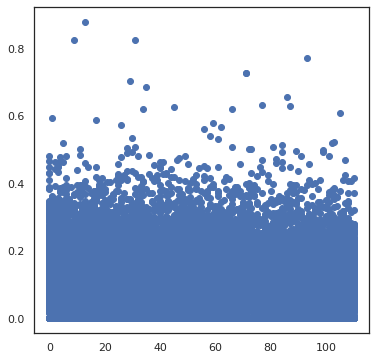

In [0]:
sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)

# Load a single subreddit
subreddit = 'depression'
df = pd.read_csv(input_dir+'reddit_mental_health_dataset/{}_{}_features.csv'.format(subreddit,pre_or_post))

feature='sent_pos'
x = df.date.values
le = preprocessing.LabelEncoder()
y = df[feature].values
x = le.fit_transform(x)
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
plt.scatter(x,y)
print('r2:',r_value**2, 'p-value: ',p_value)


r2: 0.18106204448434088 p-value:  3.230680442427489e-06


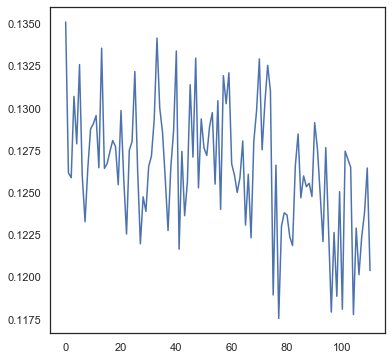

In [0]:
# Plot averaged data
df_regr = pd.DataFrame({'x':x,'y':y})
df_regr = df_regr.groupby(['x']).mean() 
df_regr.shape[0]
assert df_regr.shape[0] == len(np.unique(x))

x = df_regr.index.values
y = df_regr['y'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

plt.plot(x,y)
print('r2:',r_value**2, 'p-value: ',p_value)


# 4. Plot mean values and regression stats

In [339]:
subreddit = 'anxiety'
summary = timeseries_summary(input_dir+'reddit_mental_health_dataset/', subreddit = subreddit, pre_or_post = 'post', 
                       timestep = 2, metric='mean',weigh_by_Nwords = True, filter_days = False,zscore_slope=False)





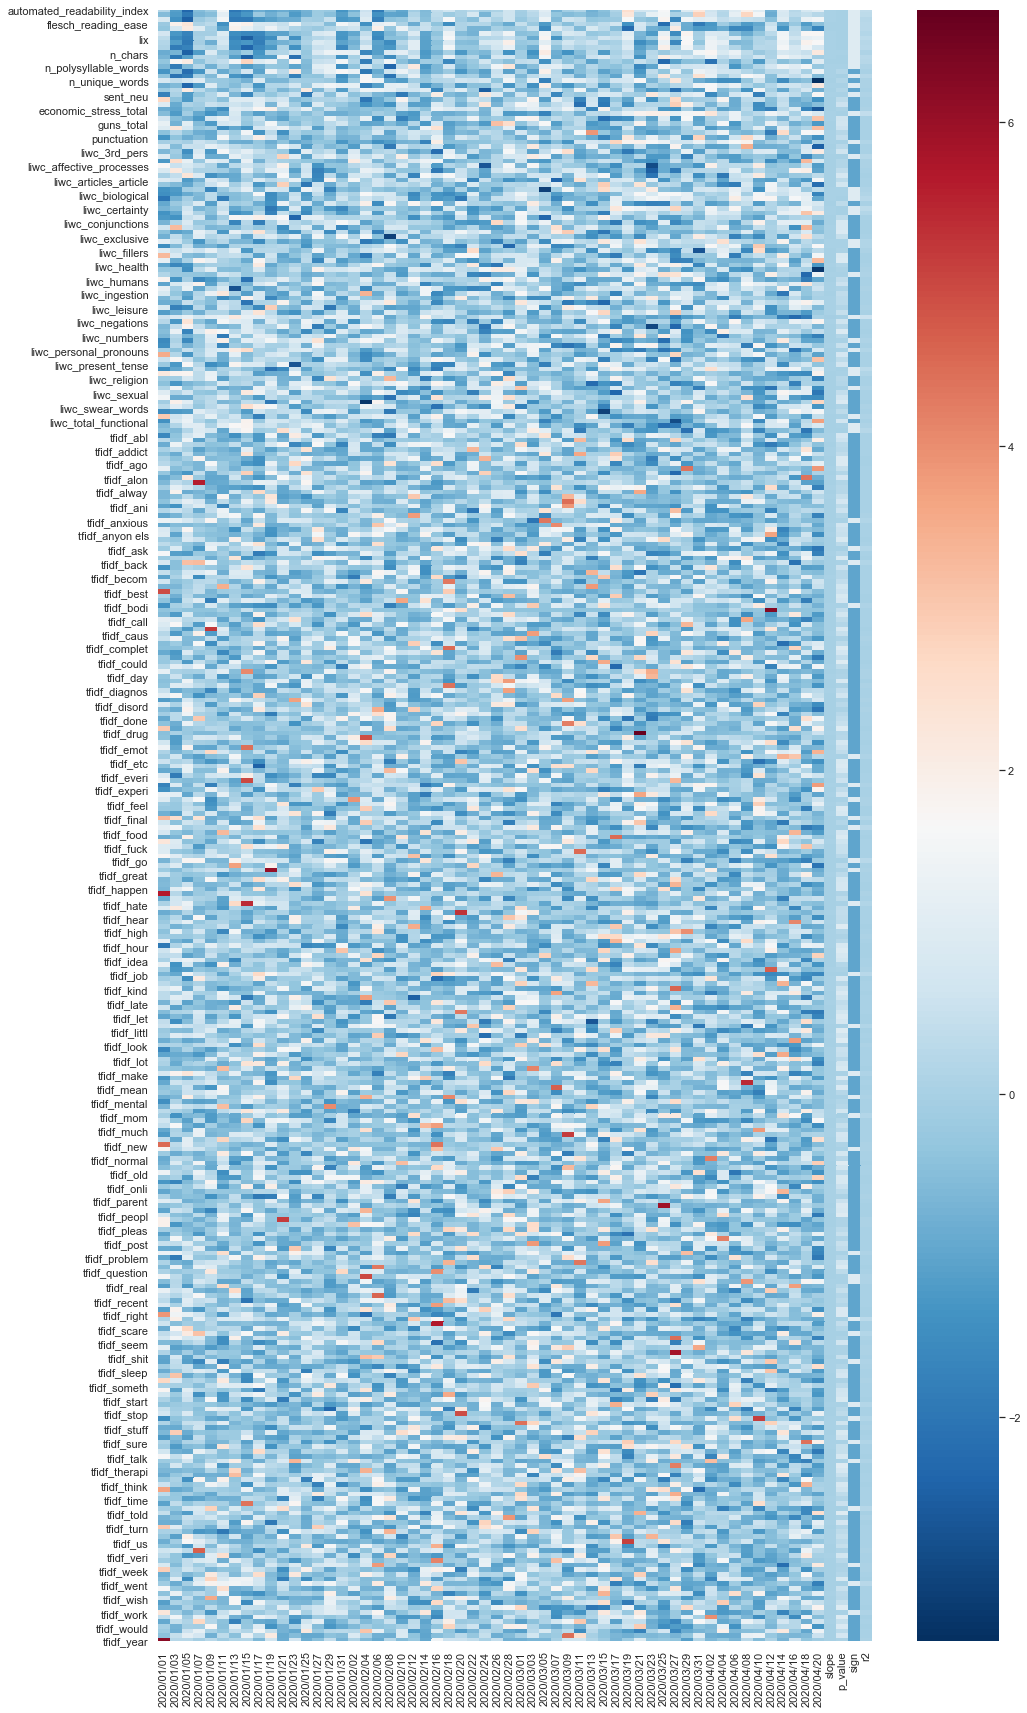

In [340]:
# Plot
sns.set(style='white', rc={'figure.figsize':(16,30)}, font_scale =1)
sns.heatmap(summary, cmap = 'RdBu_r')

In [214]:
# Interpret: Look at words in LIWC features
liwc = pd.read_csv('./../../datum/util_nlp/liwc_english_dictionary/categories.txt', sep=',').iloc[:,1].values

liwc_words = np.load('./../../datum/util_nlp/liwc_english_dictionary/liwc.npy',allow_pickle=True).item()

liwc_words['exclusive']

['but',
 'either',
 'except',
 'exclu',
 'if',
 'just',
 'not',
 'or',
 'rather',
 'really',
 'something',
 'sometime',
 'unless',
 'versus',
 'vs',
 'whether',
 'without']

## Figure S4. See some features in detail and plot regression line in color for examples


=====liwc_motion====


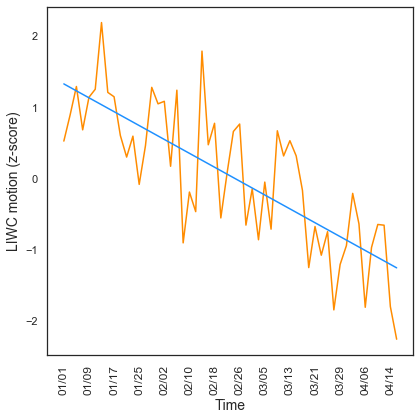

In [358]:
sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)
# for variable in keep:
for variable in ['liwc_motion']:
    print('\n====={}===='.format(variable))
    x_name = summary.columns[:-6].values
    x_name = [n.replace('2020/','') for n in x_name]
    x = range(len(x_name))
    y = summary.T[variable][:-6].values
    plt.plot(x_name,y ,color='darkorange')
    plt.title('')
    plt.ylabel('LIWC motion (z-score)', fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.xticks(np.arange(min(x), max(x)+1, 4),rotation=90, fontsize = 12)
#     plt.xticks(rotation=90)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='dodgerblue')
    plt.tight_layout()
    plt.savefig(output_dir+'trends/trend_example_down_neg_sent.png', dpi=400)
    plt.show()



=====liwc_certainty====


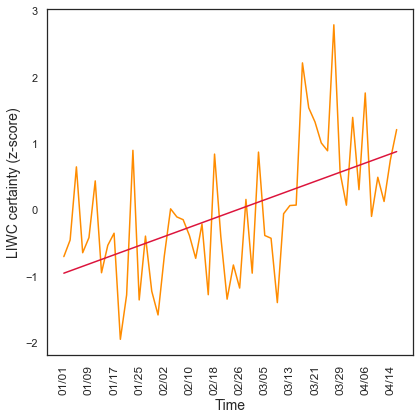

In [357]:
sns.set(style='white', rc={'figure.figsize':(6,6)}, font_scale =1)
# for variable in keep:
for variable in ['liwc_certainty']:
    print('\n====={}===='.format(variable))
    x_name = summary.columns[:-6].values
    x_name = [n.replace('2020/','') for n in x_name]
    x = range(len(x_name))
    y = summary.T[variable][:-6].values
    plt.plot(x_name,y ,color='darkorange')
    plt.title('')
    plt.ylabel('LIWC certainty (z-score)', fontsize=14)
    plt.xlabel('Time', fontsize=14)
    plt.xticks(np.arange(min(x), max(x)+1, 4),rotation=90, fontsize = 12)
#     plt.xticks(rotation=90)
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='crimson')
    plt.tight_layout()
    plt.savefig(output_dir+'trends/trend_example_up_isolation.png', dpi=400)
    plt.show()


# 5. Main summary figure: slope*r^2 for all features and all subreddits (Figure 2 and Figures S5 S6 S7)

In [10]:
from statsmodels.stats.multitest import multipletests
import json
from matplotlib.colors import DivergingNorm

In [67]:
pvals = [0.004,0.003]+[0.12]*26
pvals

[0.004,
 0.003,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12,
 0.12]

In [66]:
reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)
reject

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [11]:
def main_table(input_dir, subreddits, features, timestep =2, pre_or_post = 'post', add_subreddits_to_features=True):
    # If using older data, than we want to filter months to match 2020 data
    if pre_or_post == 'pre':
        filter_days = ['2018/']+ ['2019/04/'+str(n).zfill(2) for n in range(21,31) ]+['2019/'+str(n).zfill(2) for n in range(5,13) ]
    else:
        filter_days = False
    
    slope_all = []
    r2_all = []
    p_value_all = []

    print('loading...')
    for sr in subreddits:
        print(sr)
        summary_sr = timeseries_summary(input_dir, subreddit = sr, pre_or_post = pre_or_post, 
                           timestep = timestep, metric='mean',weigh_by_Nwords = True, zscore_slope =False,filter_days=filter_days)
        summary_sr_slope = summary_sr[['slope']]
        slope_all.append(summary_sr_slope)
        r2_all.append(summary_sr[['r2']]) 
        p_value_all.append(summary_sr[['p_value']])
    
    # Build DF from list of DFs
    df_slope = pd.concat(slope_all, axis=1) 
    df_r2 = pd.concat(r2_all, axis=1) 
    df_p_value = pd.concat(p_value_all, axis=1)

    # Add col name
    df_slope.columns = subreddits
    df_r2.columns = subreddits
    df_p_value.columns = subreddits

    # Filter features
    print('features before filtering: ',df_slope.shape)
    df_slope = df_slope.T[keep].T
    df_r2 = df_r2.T[keep].T
    df_p_value = df_p_value.T[keep].T
    print('features after filtering: ',df_slope.shape)

    # slope * r^2 
    df_slope_r2 = df_slope*df_r2

    # Multiple comparison correction
    pvals= df_p_value.values.flatten() 
    reject, pvals_corrected, alpha_sidak, alpha_bonferroni = multipletests(pvals, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)

    # Create mask with significant results
    reject_opp = np.array([not c for c in reject]) #inverse mask of booleans
    df_shape = df_p_value.shape # reshape to this shape
    df_reject = pd.DataFrame(reject_opp.reshape(df_shape))
    df_reject.columns = df_slope_r2.columns
    df_reject.index = df_slope_r2.index
    print('Significant results: ',np.sum(reject)/len(reject))
    
    if add_subreddits_to_features:
    # Y-AXIS: Add mental health subreddits that most use each feature for classification (computed only using highest coefficients (top 50%) )
        with open('./../../datum/reddit/output/classification/binary8_model0/main_sr_per_feature.json', 'r') as fp:
            max_features = json.load(fp)

        df_index = df_slope_r2.index 
        # insert into y-axis
        df_index_new = []
        for i in df_index:
            sr = max_features.get(i)
            if sr==None:
                df_index_new.append(''+i)
            else:
                df_index_new.append('({})   '.format(sr)+i)

        df_slope_r2.index = df_index_new
        df_reject.index = df_index_new
    
    return df_slope_r2, df_reject


    

In [12]:

def plot_trend_heatmap(df, mask, plot_name, savefig = True, dpi = 300):

    plt.clf()
    sns.set(style='white', rc={'figure.figsize':(16,20)}, font_scale =1)
    cmap = plt.get_cmap("RdBu_r")
    cmap.set_bad(color='white', alpha=0.1)
    # Make sure 0 is white, use same color scale as 1st figure.
    divnorm = DivergingNorm(vcenter=0)
    sns.heatmap(df, norm=divnorm, cmap =cmap,cbar = False,linewidths=0) #this one appears in the background masked 
    ax = sns.heatmap(df, cmap=cmap,norm=divnorm, cbar = False,mask=mask, linewidths=0.1,
              annot=True,annot_kws={"fontsize":10}, vmin=-0.045, vmax=0.045) #this one is for the 


    # So it won't get cutoff
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.tick_params(axis='x', which='major', labelsize=12)
    ax.tick_params(axis='y', which='major', labelsize=10)


    
    plt.ylabel('Features (important feature to classify this subreddit)',fontsize=15)
    plt.xlabel('Subreddits', fontsize=15)
    plt.tight_layout()
    if savefig:
        plt.savefig(output_dir+f'trends/{plot_name}.png', dpi=dpi)

In [15]:
# Load 2020
input_dir_reddit_mental_health_dataset = input_dir+'reddit_mental_health_dataset/'

pre_or_post = 'post'
add_subreddits_to_features=True
df_slope_r2, df_reject = main_table(input_dir_reddit_mental_health_dataset, subreddits, keep, 
                                    pre_or_post = pre_or_post, add_subreddits_to_features=add_subreddits_to_features)

loading...
COVID19_support
mentalhealth
anxiety
socialanxiety
healthanxiety
autism
adhd
ptsd
lonely
depression
suicidewatch
bipolarreddit
bpd
schizophrenia
addiction
alcoholism
EDAnonymous
personalfinance
conspiracy
guns


/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/scipy/stats/stats.py:2315: RuntimeWarning:

invalid value encountered in true_divide



legaladvice
divorce
relationships
parenting
teaching
meditation
fitness
jokes
features before filtering:  (347, 28)
features after filtering:  (91, 28)
Significant results:  0.12794348508634223


In [16]:
def replace_index(df_slope_r2, df_reject):
    index_new = list(df_slope_r2.index)
    # index_new = [n.split(')')[0][1:]+' \textbf{'+n.split(')')[1]+'}' if ')' in n else n for n in index_new]
    index_new = [n.replace('liwc_','LIWC ').replace('n ', 'N ').replace('sent_neu','neutral sentiment').replace('sent_compound','compound sentiment').replace('sent_pos','positive sentiment').replace('sent_neg','negative sentiment').replace('_total',' lexicon').replace('_', ' ').replace('oN', 'on') for n in index_new]
    df_slope_r2.index = index_new
    df_reject.index = index_new
    return df_slope_r2, df_reject

df_slope_r2, df_reject = replace_index(df_slope_r2, df_reject)

In [17]:
df_slope_r2.shape

(91, 28)

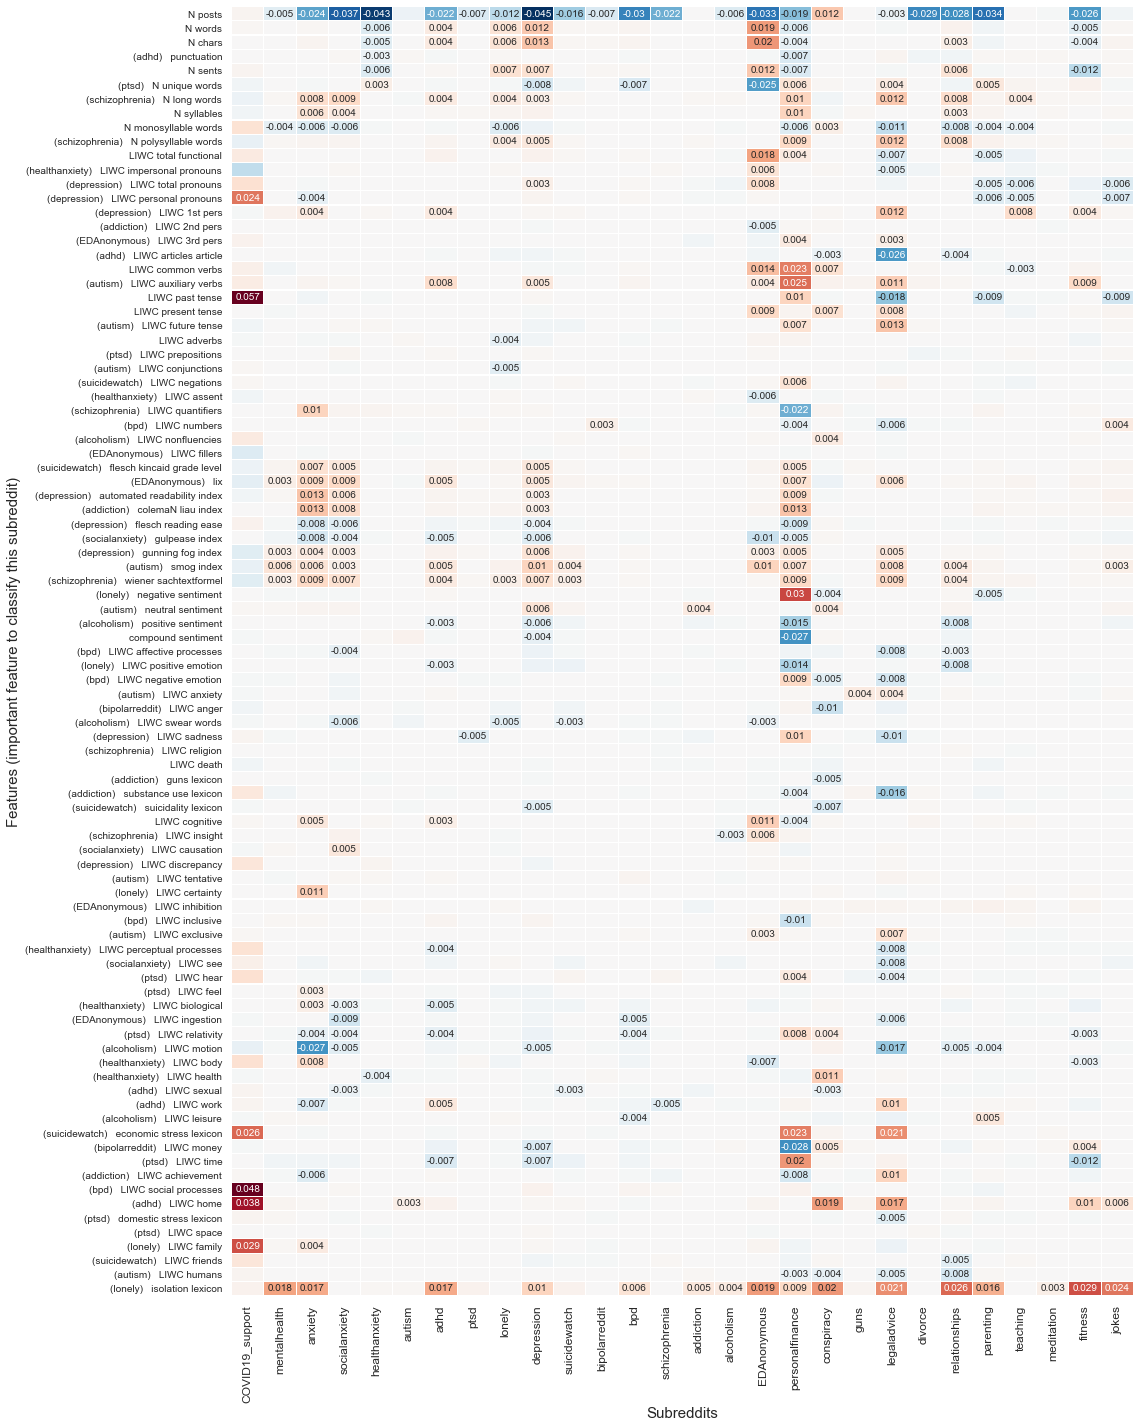

In [350]:

dpi=250

# Plot 2020 (post)
sns.set(style='white', rc={'figure.figsize':(16,20)}, font_scale =1)
pre_or_post = 'post'
plot_name = f'heatmap_slope_r2_bh_{pre_or_post}_main'
df = df_slope_r2.copy().round(3)

mask = df_reject.copy()

plot_trend_heatmap(df, mask, plot_name, savefig = True, dpi = dpi)

###  Extract examples (Table 2)

In [35]:
# Find feature-subreddit pairs with largest changes to then find examples
df = df_slope_r2.copy()
df.stack().sort_values(ascending = False).iloc[:50]

# feature high and low in the subreddits I give it. 


liwc_past_tense                             COVID19_support    0.057225
(bpd)   liwc_social_processes               COVID19_support    0.047582
(adhd)   liwc_home                          COVID19_support    0.038083
(lonely)   sent_neg                         personalfinance    0.029792
(lonely)   liwc_family                      COVID19_support    0.029144
(lonely)   isolation_total                  fitness            0.028549
                                            relationships      0.026014
(suicidewatch)   economic_stress_total      COVID19_support    0.025541
(autism)   liwc_auxiliary_verbs             personalfinance    0.024810
(lonely)   isolation_total                  jokes              0.024448
(depression)   liwc_personal_pronouns       COVID19_support    0.024303
(suicidewatch)   economic_stress_total      personalfinance    0.023102
liwc_common_verbs                           personalfinance    0.022883
(lonely)   isolation_total                  legaladvice        0

In [37]:
# Largest decreases
df.stack().sort_values(ascending = False).iloc[-50:]

(ptsd)   n_unique_words                      depression        -0.007647
n_monosyllable_words                         relationships     -0.007684
(lonely)   liwc_positive_emotion             relationships     -0.007698
(socialanxiety)   liwc_see                   legaladvice       -0.007721
(bpd)   liwc_affective_processes             legaladvice       -0.007726
(healthanxiety)   liwc_perceptual_processes  legaladvice       -0.007755
(alcoholism)   sent_pos                      relationships     -0.007799
(addiction)   liwc_achievement               personalfinance   -0.007832
(bpd)   liwc_negative_emotion                legaladvice       -0.008030
(autism)   liwc_humans                       relationships     -0.008135
(socialanxiety)   gulpease_index             anxiety           -0.008169
(depression)   flesch_reading_ease           anxiety           -0.008311
(EDAnonymous)   liwc_ingestion               socialanxiety     -0.008543
liwc_past_tense                              jokes 

In [177]:

examples = [
     ['COVID19_support', ['liwc_home','economic_stress_total']],
[ 'anxiety', ['economic_stress_total','liwc_body', 'isolation_total']],
    [ 'socialanxiety',['liwc_see']],
   [  'healthanxiety',['liwc_biological', 'liwc_health']],
  [   'depression',['sent_pos', 'gunning_fog_index', 'liwc_negations']],
 ['suicidewatch',    ['liwc_money', 'suicidality_total']],
[ 'EDAnonymous',[ 'liwc_body', 'liwc_ingestion']],
   [ 'adhd',['isolation_total', 'sent_compound', 'sent_neg', 'liwc_sadness']],
# other MH,
  [       'autism',['liwc_tentative', 'liwc_humans']],
 [    'ptsd',['guns_total', 'domestic_stress_total']],
[     'lonely', ['isolation_total']] ,
     ['bipolarreddit',['liwc_anger']],
    [ 'bpd',['liwc_numbers', 'liwc_affective_processes', 'liwc_social_processes']],
   [ 'addiction',['liwc_achievement']],
  [   'alcoholism',['liwc_nonfluencies']]    ,
# other non
 [   'personalfinance',['economic_stress_total']],
[ 'relationships',['isolation_total']],
    ['conspiracy',['liwc_home', 'liwc_health']],
    ['parenting', ['liwc_leisure']],
    ['guns',['liwc_anxiety', 'sent_pos', 'sent_compound']],
]

In [190]:
# Obtain examples for posts that score high on certain features
n = 5
results = [
    ['covid19 lexicon','r/healthanxiety (01/19): I’ve been seeing a lot of news stories today about an incurable, lethal disease originating in China spreading to other countries. I know the media often over exaggerates things like this, but WHO is debating whether or not to declare this an international emergency. Nothing triggers my anxiety worse than things like this, if anyone has any advice on how to cope/can inform me on it I would really appreciate it!']
]

for subreddit, features in examples[3:]:
    print(subreddit, features)
    # Load data
    df = pd.read_csv(input_dir+'reddit_mental_health_dataset/'+f'{subreddit}_post_features_tfidf_256.csv') #index_col = 0 depends on dataset.
    if subreddit in subreddits_mental_health:
        df_covid = pd.read_csv(input_dir+'covid19_counts/'+f'{subreddit}_post_features_covid19_counts.csv') #index_col = 0 depends on dataset.
        df = df.merge(df_covid)
        covid_mean = df.covid19_weighed_words.mean()
        df = df[df.covid19_weighed_words>covid_mean]
    df = df[df.n_words<90]
    df = df[df.n_words>20]
    
    for feature in features:
        df_sr_highest_feature = df.nlargest(n, feature)
        for post_i in range(df_sr_highest_feature.shape[0]):
            post = df_sr_highest_feature.post.values[post_i].replace('\n',' ')
            date = df_sr_highest_feature.date.values[post_i].replace('2020/','')
            score = df_sr_highest_feature[feature].values[post_i]
            results.append([f'{feature}\nr/{subreddit} ({date})', post, score])



        

healthanxiety ['liwc_biological', 'liwc_health']
depression ['sent_pos', 'gunning_fog_index', 'liwc_negations']
suicidewatch ['liwc_money', 'suicidality_total']
EDAnonymous ['liwc_body', 'liwc_ingestion']
adhd ['isolation_total', 'sent_compound', 'sent_neg', 'liwc_sadness']
autism ['liwc_tentative', 'liwc_humans']
ptsd ['guns_total', 'domestic_stress_total']
lonely ['isolation_total']
bipolarreddit ['liwc_anger']
bpd ['liwc_numbers', 'liwc_affective_processes', 'liwc_social_processes']
addiction ['liwc_achievement']
alcoholism ['liwc_nonfluencies']
personalfinance ['economic_stress_total']
relationships ['isolation_total']
conspiracy ['liwc_home', 'liwc_health']
parenting ['liwc_leisure']
guns ['liwc_anxiety', 'sent_pos', 'sent_compound']


In [192]:
cols = ['Feature\nSubreddit (date)', 'Post', 'Score']
results_df = pd.DataFrame(results, columns = cols)
index_new = results_df['Feature\nSubreddit (date)']
index_new = [n.replace('_', ' ').replace('total', 'lexicon').replace('liwc', 'LIWC') for n in index_new]
results_df.Feature = index_new
results_df.to_csv(output_dir+'/trends/posts_examples.csv', encoding = 'utf-8')

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



In [199]:
df = pd.read_csv(output_dir+'/figures/examples_posts.csv')
df = df.sort_values('Feature')
df.to_csv(output_dir+'/trends/posts_examples_v0_small_sorted.csv', encoding = 'utf-8')

#### Compare to 2019 and 2018

In [354]:
# Load from 2019
pre_or_post = '2019'
add_subreddits_to_features=True
subreddits_2019 = subreddits.copy()
subreddits_2019.remove('COVID19_support')
df_slope_r2_2019, df_reject_2019 = main_table(input_dir_reddit_mental_health_dataset, subreddits_2019, keep, pre_or_post = pre_or_post, add_subreddits_to_features=add_subreddits_to_features)


loading...
mentalhealth
anxiety
socialanxiety
healthanxiety
autism
adhd
ptsd
lonely
depression
suicidewatch
bipolarreddit
bpd
schizophrenia
addiction
alcoholism
EDAnonymous
personalfinance
conspiracy
guns
legaladvice
divorce
relationships
parenting
teaching
meditation
fitness
jokes
features before filtering:  (347, 27)
features after filtering:  (91, 27)
Significant results:  0.01912901912901913


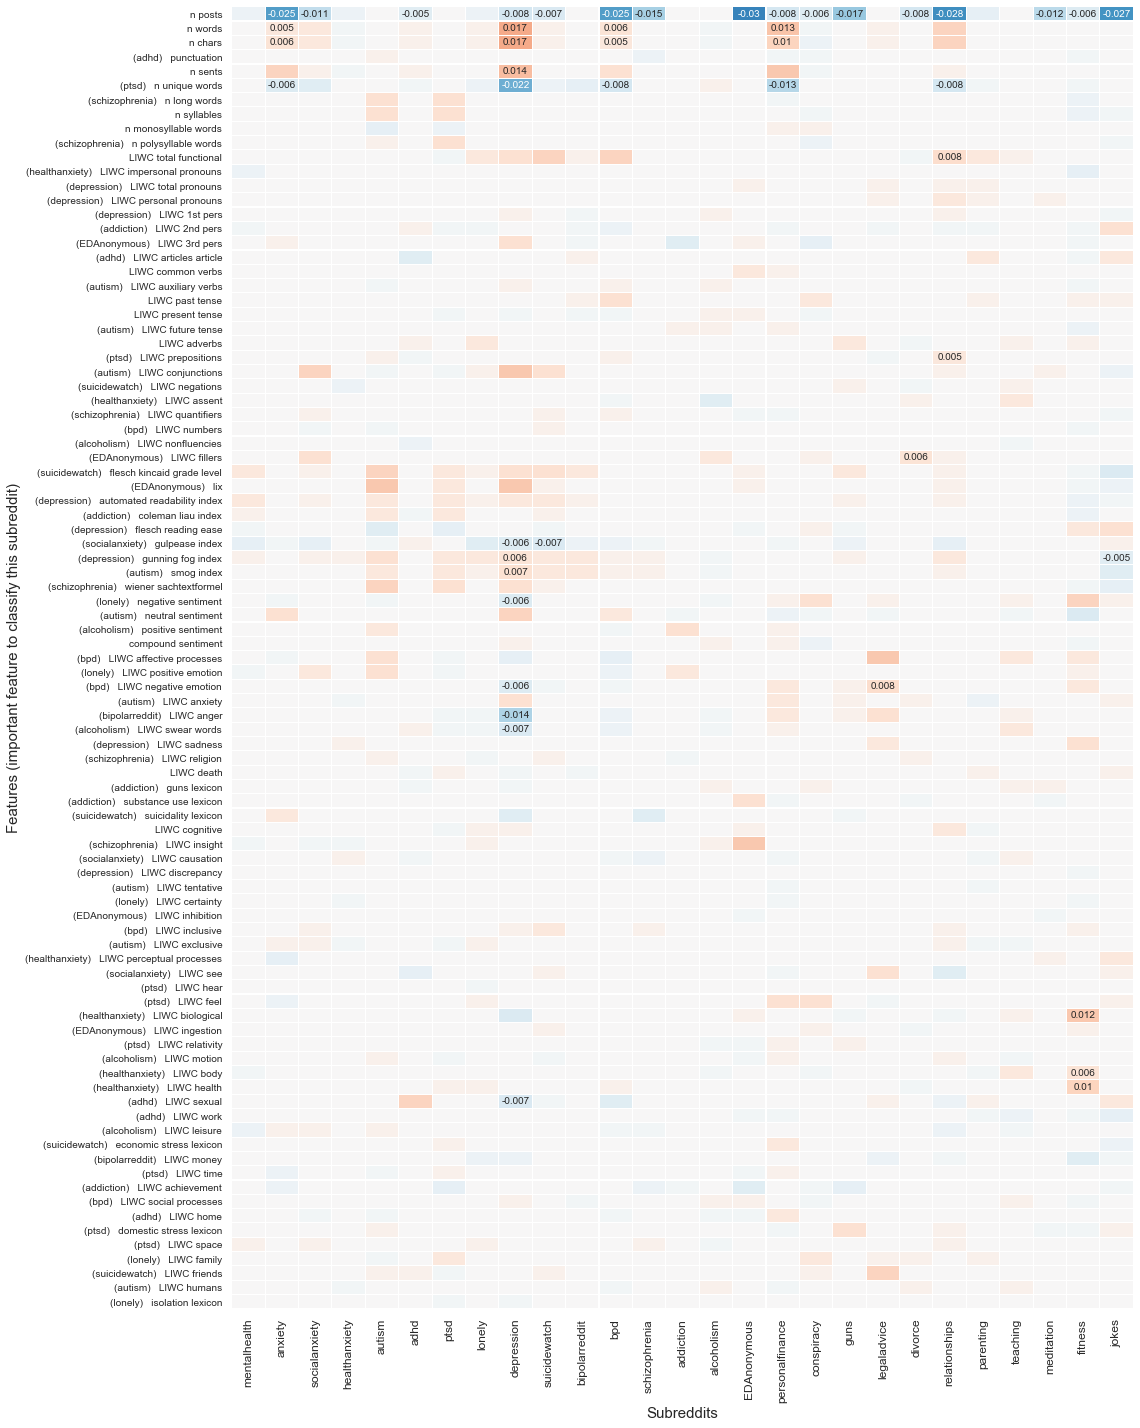

In [355]:
# Plot 2019

df_slope_r2_2019, df_reject_2019 = replace_index(df_slope_r2_2019, df_reject_2019)

pre_or_post = '2019'
plot_name = f'heatmap_slope_r2_bh_{pre_or_post}_main'
df_2019 = df_slope_r2_2019.copy().round(3)
mask_2019 = df_reject_2019.copy() #df_reject or False
plot_trend_heatmap(df_2019, mask_2019, plot_name, savefig = True, dpi = dpi)



In [256]:
# Load 2018
pre_or_post = '2018'
add_subreddits_to_features=True
subreddits_2018 = subreddits.copy()
subreddits_2018.remove('COVID19_support')
subreddits_2018.remove('EDAnonymous') #Created Nov. 18, 2018, so there's no data. 
df_slope_r2_2018, df_reject_2018 = main_table(input_dir_reddit_mental_health_dataset,subreddits_2018, keep, pre_or_post = pre_or_post, add_subreddits_to_features=add_subreddits_to_features)

df_slope_r2_2018, df_reject_2018 = replace_index(df_slope_r2_2018, df_reject_2018)



loading...
mentalhealth
anxiety
socialanxiety
healthanxiety
autism
adhd
ptsd
lonely
depression
suicidewatch
bipolarreddit
bpd
schizophrenia
addiction
alcoholism
personalfinance
conspiracy
guns
legaladvice
divorce
relationships
parenting
teaching
meditation
fitness
jokes
features before filtering:  (347, 26)
features after filtering:  (91, 26)
Significant results:  0.013947590870667794


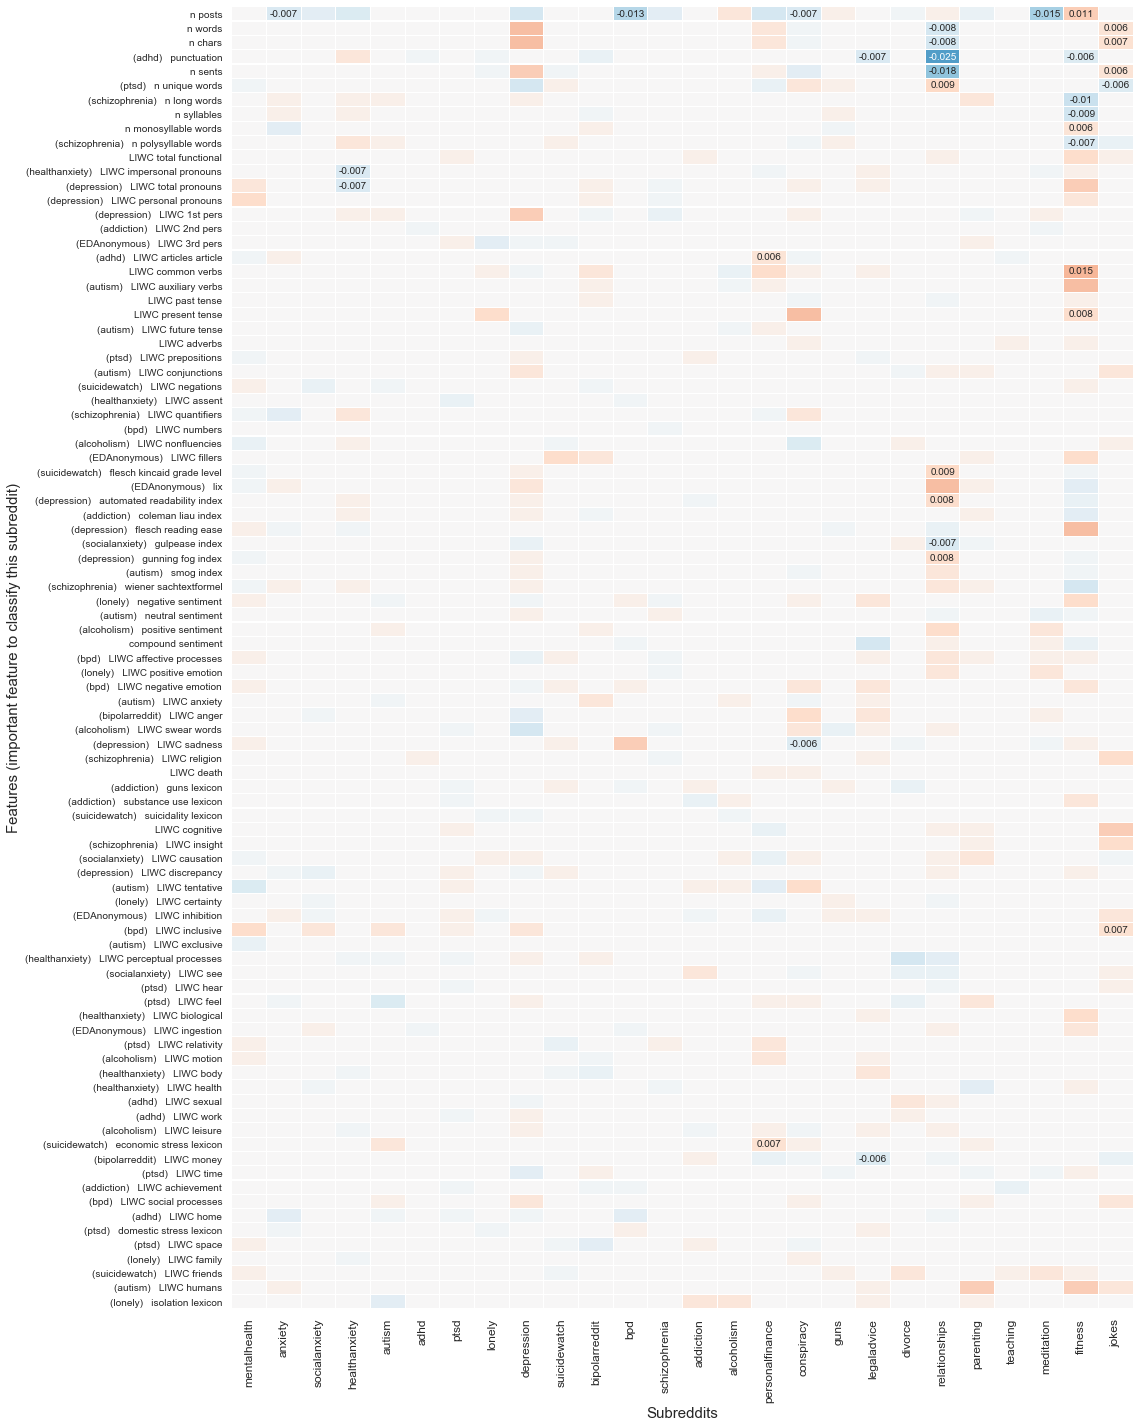

In [356]:
# Plot 2018
pre_or_post = '2018'
plot_name = f'heatmap_slope_r2_bh_{pre_or_post}_main'
df = df_slope_r2_2018.copy().round(3)
mask = df_reject_2018.copy() #df_reject or False
plot_trend_heatmap(df, mask, plot_name, savefig = True, dpi = dpi)

### We decided to show the 3 figures instead of subtractions

Whitney U (3771506.0) = 2.0226989631901272e-36
Whitney U (3761154.0) = 2.325868285455749e-51
Whitney U (3038929.0) = 0.0062057110979603725


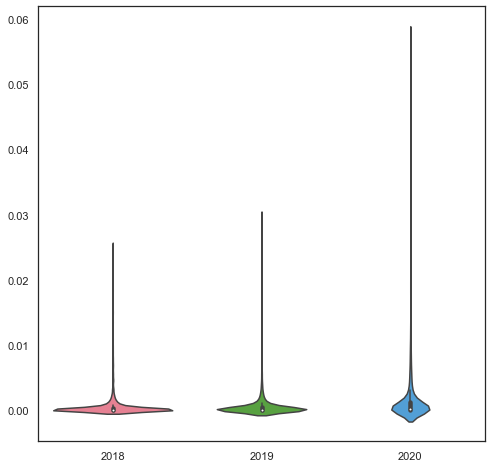

In [258]:
from scipy.stats import mannwhitneyu

# Boxplot
sns.set(style='white', rc={'figure.figsize':(8,8)}, font_scale =1)
flat_2020 = np.abs(df_slope_r2.values.flatten())
flat_2019 = np.abs(df_slope_r2_2019.values.flatten())
flat_2018 = np.abs(df_slope_r2_2018.values.flatten())
y = np.concatenate((flat_2020,flat_2019,flat_2018))
x = ['2020']*len(flat_2020) + ['2019']*len(flat_2019) + ['2018']*len(flat_2018)
sns.violinplot(x = x , y = y, palette='husl')


s_1,p_1 = mannwhitneyu(flat_2020,flat_2019, alternative='greater')
s_2,p_2 = mannwhitneyu(flat_2020,flat_2018, alternative='greater')
s_3,p_3 = mannwhitneyu(flat_2019,flat_2018, alternative='two-sided')
print(f'Whitney U ({s_1}) = {p_1}')
print(f'Whitney U ({s_2}) = {p_2}')
print(f'Whitney U ({s_3}) = {p_3}')


# Which mental health subreddits changed most?
Sum slope*r^2 across features for each


In [34]:
# Load 2020 without adding important features to y-axis
input_dir_reddit_mental_health_dataset = input_dir+'reddit_mental_health_dataset/'

pre_or_post = 'post'
add_subreddits_to_features=False
df_slope_r2, df_reject = main_table(input_dir_reddit_mental_health_dataset, subreddits, keep, 
                                    pre_or_post = pre_or_post, add_subreddits_to_features=add_subreddits_to_features)

loading...
COVID19_support
mentalhealth
anxiety
socialanxiety
healthanxiety
autism
adhd
ptsd
lonely
depression
suicidewatch
bipolarreddit
bpd
schizophrenia
addiction
alcoholism
EDAnonymous
personalfinance
conspiracy
guns
legaladvice
divorce
relationships
parenting
teaching
meditation
fitness
jokes
features before filtering:  (347, 28)
features after filtering:  (91, 28)
Significant results:  0.12794348508634223


In [35]:
emotional_features = ['sent_compound', 'sent_pos','liwc_positive_emotion', #weigh pos features * -1
    'sent_neg', 'economic_stress_total',
       'isolation_total', 'substance_use_total', 'guns_total',
       'domestic_stress_total', 'suicidality_total',  
'liwc_anger',
       'liwc_anxiety',  'liwc_death', 'liwc_negations',
       'liwc_negative_emotion','liwc_sadness', ]
        


In [36]:
# Remove parenthesis with important feature from y-axis
df_top_effects = df_slope_r2.copy()
# clean_index = list(df_slope_r2.index)
# clean_index = [n.split(')   ')[1] if ')' in n else n for n in clean_index]
# df_top_effects.index = clean_index


In [48]:
# Remove non-significant changes
top_effects_all = df_top_effects[~df_reject].abs().sum().sort_values()[::-1]
top_effects_all = top_effects_all.reset_index()
top_effects_all.columns = ['subreddit', 'Σ |slope| x R^2\n all features']
top_effects_all.to_csv(output_dir+'/trends/all_change.csv')
print(top_effects_all.round(3).to_latex(index=False))

\begin{tabular}{lr}
\toprule
       subreddit &  Σ |slope| x R\textasciicircum 2\textbackslash n all features \\
\midrule
 personalfinance &                           0.484 \\
     legaladvice &                           0.363 \\
     EDAnonymous &                           0.251 \\
         anxiety &                           0.232 \\
 COVID19\_support &                           0.222 \\
      depression &                           0.198 \\
   socialanxiety &                           0.146 \\
   relationships &                           0.138 \\
      conspiracy &                           0.137 \\
         fitness &                           0.122 \\
            adhd &                           0.118 \\
       parenting &                           0.099 \\
   healthanxiety &                           0.071 \\
          lonely &                           0.061 \\
           jokes &                           0.059 \\
             bpd &                           0.056 \\
    mentalhea

In [53]:
# Weigh negatively 'sent_compound', 'sent_pos','liwc_positive_emotion',

# Look at only negative features
df_filtered2 = df_top_effects.T[emotional_features].T

for feature in ['sent_compound', 'sent_pos','liwc_positive_emotion']:
    df_filtered2.loc[feature] = df_filtered2.loc[feature] * -1


top_effects_emotional = df_filtered2[~df_reject].sum().sort_values()[::-1]
top_effects_emotional = top_effects_emotional.reset_index()
top_effects_emotional.columns = ['subreddit', 'Σ slope x R^2\n neg. features']
top_effects_emotional
print(top_effects_emotional.round(3).to_latex(index=False))
top_effects_emotional.to_csv(output_dir+'/trends/sum_negative_change.csv')
print(', '.join(emotional_features))

\begin{tabular}{lr}
\toprule
       subreddit &  Σ slope x R\textasciicircum 2\textbackslash n neg. features \\
\midrule
 personalfinance &                          0.139 \\
   relationships &                          0.042 \\
         fitness &                          0.029 \\
 COVID19\_support &                          0.026 \\
           jokes &                          0.024 \\
            adhd &                          0.023 \\
     EDAnonymous &                          0.019 \\
    mentalhealth &                          0.018 \\
         anxiety &                          0.017 \\
      depression &                          0.014 \\
       parenting &                          0.010 \\
     legaladvice &                          0.007 \\
             bpd &                          0.006 \\
       addiction &                          0.005 \\
      alcoholism &                          0.004 \\
            guns &                          0.004 \\
      meditation &            

In [90]:
top_effects  = pd.concat([top_effects_all, top_effects_emotional], axis=1)
print(top_effects.to_latex(index=False))

\begin{tabular}{lrlr}
\toprule
       subreddit &  Σ |slope| x R\textasciicircum 2\textbackslash n all features &        subreddit &  Σ slope x R\textasciicircum 2\textbackslash n neg. emotional features \\
\midrule
 personalfinance &                           0.484 &  personalfinance &                                    0.133 \\
     legaladvice &                           0.363 &    relationships &                                    0.042 \\
     EDAnonymous &                           0.251 &          fitness &                                    0.029 \\
         anxiety &                           0.232 &  COVID19\_support &                                    0.026 \\
 COVID19\_support &                           0.222 &            jokes &                                    0.024 \\
      depression &                           0.198 &             adhd &                                    0.023 \\
   socialanxiety &                           0.146 &      EDAnonymous &               

In [58]:
## Does health anxiety topic increase pre- vs mid?

In [68]:

input_dir = './../../datum/reddit/input/'
df_pre = pd.read_csv(input_dir+'lda_pre_health_anxiety.csv', index_col=0)
new_index  = list(df_pre.index)
new_index = [n.replace('_pre_features', '') for n in new_index]
df_pre.index = new_index
df_pre.columns = ['pre']


df_mid = pd.read_csv(input_dir+'lda_mid_health_anxiety.csv', index_col=0)
new_index  = list(df_mid.index)
new_index = [n.replace('_post_features', '') for n in new_index]
df_mid.index = new_index
df_mid.columns = ['mid']
df = pd.concat([df_pre, df_mid],axis=1)
df = df.drop('COVID19_support',axis=0) #not available in 2019

df.shape

from scipy.stats import wilcoxon, spearmanr
lda_pre = df['pre']
lda_mid = df['mid']

t,p_value = wilcoxon(x=lda_pre.values, y = lda_mid.values, alternative = 'two-sided')
print('P-value for comparison between distribution of health anxiety LDA topic in pre- vs mid-pandemic posts', p_value)



P-value for comparison between distribution of health anxiety LDA topic in pre- vs mid-pandemic posts 0.00822357568152612


/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




### Comparing across analysis: LDA, Trend analysis


In [59]:

# Load trends 
trends_change = pd.read_csv(input_dir+'sum_negative_change.csv', index_col=0)
trends_change = trends_change.set_index('subreddit')

# LDA change
lda_change = lda_mid-lda_pre

# Concat both
trends_lda = pd.concat([trends_change, lda_change], axis=1)

# trends_lda = trends_lda.drop('healthanxiety')
trends_lda = trends_lda.dropna()
trends_lda.columns = ['Neg. semantic change','Increase in Health Anx. topic']


trends_lda = trends_lda.sort_values('Neg. semantic change')[::-1].round(3)
# trends_lda.to_csv(output_dir+'comparison_across_analyses.csv')
trends_lda 

c,p = spearmanr(trends_lda .values[:,0],trends_lda .values[:,1],)
print(c.round(3), p.round(3))

-0.046 0.819


/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




## Select subset of table for presentation

In [296]:




def plot_small_trend_analysis(df, df_reject, output_name, title=''):
    plt.clf()
    sns.set(style='white',font='arial', rc={'figure.figsize':(12,12)}, font_scale =1.3)
    cmap = plt.get_cmap("RdBu_r")
    cmap.set_bad(color='white', alpha=0.1)

    divnorm = DivergingNorm(vcenter=0)
    sns.heatmap(df_filtered_small, norm=divnorm, cmap ="RdBu_r",cbar = False,linewidths=0.1, square=True,vmin=-0.045, vmax=0.045)

    # mask
    # sns.set(font_scale=2)
    ax = sns.heatmap(df.round(3), cmap=cmap, norm=divnorm,  cbar = False,mask=df_reject, linewidths=0.1,
                annot=True,annot_kws={"fontsize":12},vmin=-0.045, vmax=0.045)


    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    # plt.title('R^2 * sign of the slope')
    plt.tight_layout()
    plt.ylabel('Features (important feature to classify this subreddit)',fontsize=15)
    plt.xlabel('Subreddits', fontsize=15)
    # ax.ax_heatmap.set_yticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
    # ax.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 12)

    # plt.yticks(labels = list(df_filtered_small.index), fontsize=12)
    # plt.xticks(labels = list(df_filtered_small.columns), fontsize=12)
    plt.title(title,fontweight="bold")
    plt.tight_layout()
    plt.savefig(output_dir+f'trends/{output_name}.png', dpi=400)
 




In [0]:
subreddits

['addiction',
 'guns',
 'socialanxiety',
 'schizophrenia',
 'healthanxiety',
 'suicidewatch',
 'EDAnonymous',
 'mentalhealth',
 'COVID19_support',
 'teaching',
 'fitness',
 'personalfinance',
 'meditation',
 'bipolarreddit',
 'adhd',
 'conspiracy',
 'autism',
 'mentalillness',
 'alcoholism',
 'bpd',
 'ptsd',
 'divorce',
 'legaladvice',
 'jokes',
 'mindfulness',
 'anxiety',
 'depression',
 'parenting',
 'relationships',
 'lonely']

In [312]:

# features_small = ['n_posts','n_words','sent_neg', 'sent_pos','economic_stress_total', 'isolation_total',
#              'liwc_motion', 'liwc_home','liwc_body','liwc_past_tense',]

features_small = ['n_posts','n_words','sent_neg', 'sent_pos','economic_stress_total', 'isolation_total',
             'liwc_motion', 'liwc_home', 'liwc_body']

subreddits_small = [
     'COVID19_support',
 'anxiety',
     'socialanxiety',
     'healthanxiety',
     'depression',
 'suicidewatch',    
 'EDAnonymous',
    'adhd',

 'personalfinance',
 'relationships',
    'conspiracy',
    'parenting', 
    'divorce'
]



In [320]:

# Y-AXIS: Add mental health subreddits that most use each feature for classification (computed only using highest coefficients (top 50%) )
with open('./../../datum/reddit/output/classification/binary8_model0/main_sr_per_feature.json', 'r') as fp:
    max_features = json.load(fp)


# insert subreddits into y-axis
features_small_sr = []
for i in features_small:
    sr = max_features.get(i)
    if sr==None:
        features_small_sr.append(''+i)
    else:
        features_small_sr.append('({})   '.format(sr)+i)


# clean
features_small_sr = [n.replace('liwc','LIWC').replace('n_', 'N_').replace('sent_neu','neutral sentiment').replace('sent_compound','compound sentiment').replace('sent_pos','positive sentiment').replace('sent_neg','negative sentiment').replace('_total',' lexicon').replace('_', ' ').replace('oN', 'on') for n in features_small_sr]
print(features_small_sr)

['N posts', 'N words', '(lonely)   negative sentiment', '(alcoholism)   positive sentiment', '(suicidewatch)   economic stress lexicon', '(lonely)   isolation lexicon', '(alcoholism)   LIWC motion', '(adhd)   LIWC home', '(healthanxiety)   LIWC body']


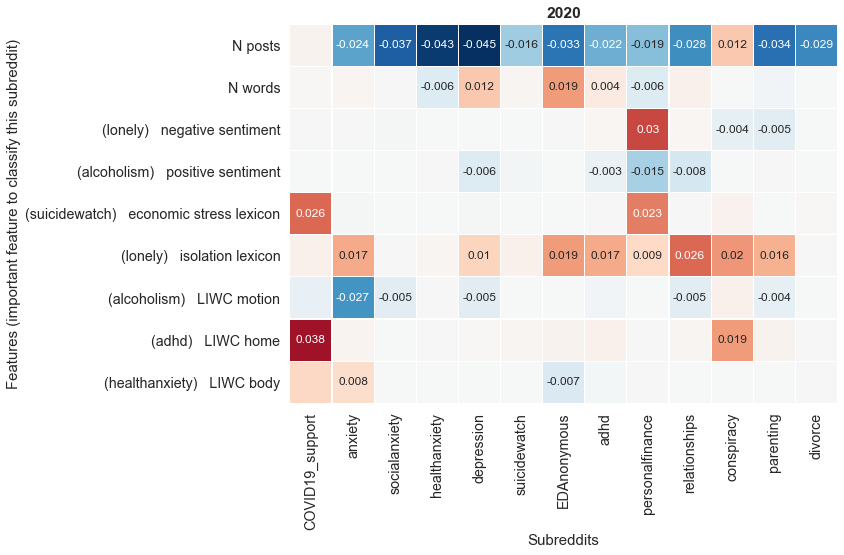

In [324]:
# 2020
sns.set(style='white',font='arial', rc={'figure.figsize':(12,12)}, font_scale =1.3)
title='2020'
# filter subreddits



df_filtered_small = df_slope_r2[subreddits_small]
df_reject_small = df_reject[subreddits_small]

# filter features
df_filtered_small = df_filtered_small.T[features_small_sr].T
df_reject_small = df_reject_small.T[features_small_sr].T


new_index = df_filtered_small.index
new_index = [n.replace('liwc_','LIWC ').replace('n_', 'N_').replace('sent_neu','neutral sentiment').replace('sent_compound','compound sentiment').replace('sent_pos','positive sentiment').replace('sent_neg','negative sentiment').replace('_total',' lexicon').replace('_', ' ').replace('oN', 'on') for n in new_index]
# new_columns = [n.replace('liwc_','').replace('_total','').replace('sent_', 'sentiment ').replace('_', ' ') for n in new_index]

df_reject_small.index = new_index
df_filtered_small.index = new_index
plot_small_trend_analysis(df_filtered_small, df_reject_small, f'heatmap_slope_r2_bh_{title}_small', title=title)

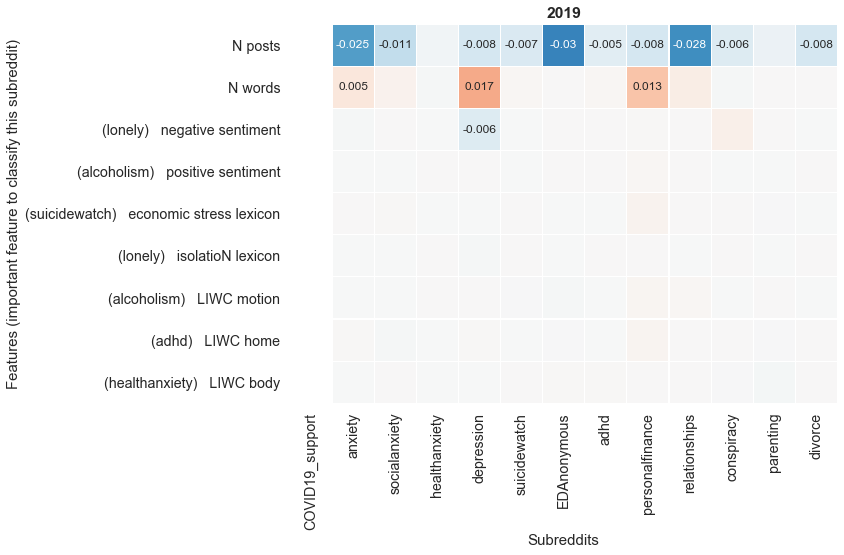

In [325]:
sns.set(style='white',font='arial', rc={'figure.figsize':(12,12)}, font_scale =1.3)
# 2019
title = '2019'
# Filter subreddits
subreddits_small_2019 = subreddits_small.copy()
subreddits_small_2019.remove('COVID19_support')
df_filtered_small = df_slope_r2_2019[subreddits_small_2019]
df_reject_small = df_reject_2019[subreddits_small_2019]

# filter features
df_filtered_small = df_filtered_small.T[features_small_sr].T
df_reject_small = df_reject_small.T[features_small_sr].T

# Create blank col or covid19 support
df_filtered_small['COVID19_support'] = [np.nan]*df_filtered_small.shape[0]
df_reject_small['COVID19_support'] = [True]*df_filtered_small.shape[0]
cols = df_filtered_small.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_filtered_small = df_filtered_small[cols]
df_reject_small = df_reject_small[cols]

new_index = df_filtered_small.index
new_index = [n.replace('liwc_','LIWC ').replace('n ', 'N ').replace('sent_neu','neutral sentiment').replace('sent_compound','compound sentiment').replace('sent_pos','positive sentiment').replace('sent_neg','negative sentiment').replace('_total',' lexicon').replace('_', ' ') for n in new_index]
# new_columns = [n.replace('liwc_','').replace('_total','').replace('sent_', 'sentiment ').replace('_', ' ') for n in new_index]

df_reject_small.index = new_index
df_filtered_small.index = new_index


plot_small_trend_analysis(df_filtered_small, df_reject_small, f'heatmap_slope_r2_bh_{title}_small', title=title)

# 6. Mean scores before and after and stats (instead of doing regression) 

In [193]:
from scipy.stats import wilcoxon
from sklearn.preprocessing import MinMaxScaler, StandardScaler


In [297]:
emotional_features = ['sent_compound', 'sent_pos','liwc_positive_emotion', #weigh pos features * -1
    'sent_neg', 'economic_stress_total',
       'isolation_total', 'substance_use_total', 'guns_total',
       'domestic_stress_total', 'suicidality_total',  
'liwc_anger',
       'liwc_anxiety',  'liwc_death', 'liwc_negations',
       'liwc_negative_emotion','liwc_sadness', ]
        

    
def preprocess_emotional_features(df_sr_filtered_by_days, df_sr):
    # Filter to only emotional features
    df_filtered = df_sr_filtered_by_days[emotional_features]
    df_filtered_all = df_sr[emotional_features]

# # #     Inversely weigh positive features 
#     for feature in ['sent_compound', 'sent_pos','liwc_positive_emotion']:
#         df_filtered[feature] = df_filtered[feature] * -1
        
    

    # Normalize count features
    weigh = emotional_features.copy()
#     Remove features that shouldn't be normalized because they don't correlate with n_words
    [weigh.remove(n) for n in ['sent_neg', 'sent_pos',
                               'sent_compound']]
    df_filtered[weigh] = df_filtered[weigh].div(df_sr_filtered_by_days['n_words'].values, axis=0)
    df_filtered_all[weigh] = df_filtered_all[weigh].div(df_sr['n_words'].values, axis=0)

    # Scaler
    # df_filtered = df_filtered.apply(zscore, axis=0)
#     scaler = MinMaxScaler()    
    scaler = StandardScaler()    
    scaler.fit_transform(df_filtered_all) #fit on whole data first
    df_filtered[df_filtered.columns]= scaler.transform(df_filtered[df_filtered.columns]) #if not scaler returns array, not DF

#     df_filtered = df_filtered.T.rename({'sent_compound':'sent_compound_inv', 'sent_pos':'sent_pos_inv','liwc_positive_emotion':'liwc_positive_emotion_inv'}).T
    
    return df_filtered

import datetime
def dates(start, end):
    index = pd.date_range(start, end)
    days = [str(n)[:-9].replace('-', '/') for n in list(index)]
    return days

In [299]:
"I was thinking while there were subreddits that had the most negative change during covid (e.g., adhd, EDAnonymous), it’s not clear how negative they became (the final absolute value, compared to other subreddits like SuicideWatch). So if I take the mean value for posts before (Jan-Febr 2020) vs. after the spike in COVID19 posts  (March11-April20), I get this: "






'I was thinking while there were subreddits that had the most negative change during covid (e.g., adhd, EDAnonymous), it’s not clear how negative they became (the final absolute value, compared to other subreddits like SuicideWatch). So if I take the mean value for posts before (Jan-Febr 2020) vs. after the spike in COVID19 posts  (March11-April20), I get this: '

In [300]:

days_before = dates(datetime.datetime(2020, 1, 1), datetime.datetime(2020, 3, 1))
days_after = dates(datetime.datetime(2020, 3, 11), datetime.datetime(2020, 4, 20))



In [333]:
# compound = [subreddit, mean_std_before, mean_std_after, sign ]
for subreddit in subreddits:
    df = pd.read_csv(input_dir+'reddit_mental_health_dataset/'+f'{subreddit}_post_features_tfidf_256.csv') #index_col = 0 depends on dataset.
    df_before = df[df.date.isin(days_before)]
    df_after = df[df.date.isin(days_after)]
    df_before_preprocessed = preprocess_emotional_features(df_before, df)
    df_after_preprocessed = preprocess_emotional_features(df_after, df)
    
    # mean
    mean_before = df_before_preprocessed.mean()
    mean_after = df_after_preprocessed.mean()
    
        # Difference
    mean_difference =  mean_after-mean_before    
    
    # p_values     
    p_values = []
    for feature in emotional_features:

        values_before = df_before_preprocessed[feature].values
        values_after = df_after_preprocessed[feature].values
        
        subsample = np.min([len(values_before), len(values_after)])
        values_before = random.sample(list(values_before), subsample)
        values_after = random.sample(list(values_after), subsample)
        
        try: t, p_value = wilcoxon(values_before, y=values_after, zero_method='wilcox', correction=False)
        except: 
            p_value = 1
        p_values.append([feature, p_value, subsample])

    p_values = np.array(p_values)
    p_values = pd.DataFrame(p_values[:,1:], index=p_values[:,0]).round(4)

    #     concat
    df_concat = pd.concat([mean_before, mean_after,mean_difference, p_values], axis=1)
    

    df_concat.columns = ['Before', 'After', 'Difference', 'p-value', 'subsample']
    df_concat = df_concat.sort_values('p-value')
    
    # Percent Change     
#     mean_pct_change = mean_pct_change.replace([np.inf, -np.inf], np.nan)
#     mean_pct_change = df_concat.pct_change(axis='columns').iloc[:,1]*100 #pct_change doesn't work with zero values
#     mean_pct_change = mean_pct_change.round(0)
#     mean_pct_change = np.array([int(n) for n in mean_pct_change])
#     df_concat = pd.concat([df_concat,mean_pct_change], axis=1)
#     df_concat.columns = ['Before', 'After', 'Perc. Change']
#     df_concat = df_concat.sort_values('Perc. Change')

    df_concat.loc['Mean'] =     df_concat.mean(axis=0)
    print(subreddit, '\n', df_concat.round(4))

# Only sum significant differences?

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

COVID19_support 
                        Before   After  Difference               p-value  \
sent_pos               0.3262  0.0058     -0.3203  0.013061605886398396   
sent_compound          0.2580  0.0083     -0.2497   0.06186574638446707   
suicidality_total      0.2363 -0.0099     -0.2462   0.06788915486182899   
sent_neg               0.2965 -0.0329     -0.3295   0.08149613521812979   
liwc_death             0.3253 -0.0069     -0.3321   0.08686008151624075   
liwc_anxiety           0.2055 -0.0292     -0.2347   0.13051556018293256   
isolation_total       -0.2009  0.0183      0.2192   0.19144640357050802   
substance_use_total   -0.1569  0.0011      0.1581   0.20757844233562428   
domestic_stress_total -0.0624  0.0055      0.0679   0.31731050786291415   
liwc_anger             0.2014 -0.0372     -0.2385    0.3793746688088797   
economic_stress_total -0.3682  0.0256      0.3938    0.4703377962613965   
liwc_sadness           0.0222 -0.0131     -0.0353   0.47812547119613813   
liwc_po

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

mentalhealth 
                        Before   After  Difference                 p-value  \
domestic_stress_total -0.0182  0.0228      0.0410    0.005467126361686497   
substance_use_total    0.0215 -0.0344     -0.0558    0.016219850311358024   
liwc_sadness           0.0089 -0.0059     -0.0149    0.024501648551396617   
liwc_positive_emotion  0.0163 -0.0182     -0.0345     0.06378282108580514   
sent_compound         -0.0012 -0.0118     -0.0106     0.11712545741132667   
sent_pos               0.0065 -0.0174     -0.0239       0.193944871796767   
liwc_negations         0.0006 -0.0065     -0.0071     0.25198548604640725   
sent_neg               0.0052 -0.0010     -0.0062      0.2859469921919492   
suicidality_total      0.0090 -0.0052     -0.0141      0.3704572617096855   
guns_total            -0.0057  0.0130      0.0187     0.37046764921998254   
economic_stress_total -0.0020 -0.0057     -0.0037       0.623401520776323   
liwc_anger            -0.0008  0.0008      0.0016      0.7739

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

anxiety 
                        Before   After  Difference                p-value  \
liwc_death            -0.0040  0.0078      0.0118   0.011817487921446075   
liwc_sadness           0.0160 -0.0311     -0.0471    0.01514785803372346   
liwc_negative_emotion  0.0113 -0.0259     -0.0371      0.079462950909025   
suicidality_total     -0.0031  0.0091      0.0122    0.12817942112917177   
sent_neg               0.0128 -0.0180     -0.0308    0.14465743767093225   
economic_stress_total  0.0069 -0.0252     -0.0321     0.1778130017899736   
substance_use_total    0.0006 -0.0082     -0.0087     0.2184086997196495   
liwc_negations        -0.0050  0.0107      0.0157     0.3329655179006715   
liwc_anxiety           0.0025 -0.0069     -0.0094    0.44608239614320233   
liwc_anger             0.0054 -0.0129     -0.0183     0.5225435844748183   
domestic_stress_total  0.0105 -0.0135     -0.0241     0.5314680167065762   
sent_pos               0.0020 -0.0113     -0.0133     0.5880773697638397   
gu

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

socialanxiety 
                        Before   After  Difference               p-value  \
substance_use_total    0.0125 -0.0536     -0.0661  0.022968846683180787   
isolation_total       -0.0076  0.0481      0.0557  0.025310114949541124   
liwc_anxiety           0.0137 -0.0349     -0.0486   0.21555488683979107   
liwc_death             0.0134 -0.0359     -0.0493   0.28222090713854386   
economic_stress_total  0.0020 -0.0051     -0.0072    0.3113802634586774   
liwc_anger             0.0194 -0.0065     -0.0260    0.3168923214972965   
guns_total             0.0082 -0.0126     -0.0208    0.3957522466577532   
sent_neg               0.0116 -0.0219     -0.0335   0.44389345376941347   
liwc_negations         0.0203 -0.0465     -0.0668    0.4889233816073115   
domestic_stress_total  0.0196 -0.0416     -0.0612    0.5423234433678905   
liwc_positive_emotion -0.0032 -0.0252     -0.0220    0.5515002104809476   
liwc_negative_emotion  0.0256 -0.0494     -0.0750    0.5772284829483246   
sent_pos 

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

healthanxiety 
                        Before   After  Difference              p-value  \
isolation_total       -0.0242  0.0803      0.1045   0.1260015467656954   
guns_total             0.0209 -0.0433     -0.0643  0.19292311977177423   
liwc_anger            -0.0231  0.0434      0.0665  0.21398116628723174   
liwc_death             0.0027  0.0133      0.0106   0.2438707937567035   
liwc_anxiety           0.0046  0.0057      0.0011  0.24748825989714462   
substance_use_total    0.0043 -0.0307     -0.0350  0.26483267445836634   
domestic_stress_total -0.0080  0.0286      0.0366  0.32207523283525596   
sent_compound         -0.0284  0.0321      0.0605    0.399617925450813   
economic_stress_total  0.0130 -0.0221     -0.0351   0.6429972942008462   
liwc_sadness           0.0182 -0.0234     -0.0416   0.6439470397603291   
liwc_positive_emotion -0.0085 -0.0142     -0.0057   0.6781374052247424   
liwc_negations        -0.0059 -0.0095     -0.0036   0.7139090003322235   
suicidality_total     

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

autism 
                        Before   After  Difference                 p-value  \
liwc_negative_emotion  0.0163 -0.0913     -0.1076  0.00024906633681566465   
liwc_anger             0.0181 -0.0838     -0.1019   0.0007877335066928876   
liwc_death             0.0284 -0.0495     -0.0779    0.004417383408275708   
liwc_sadness           0.0075 -0.0489     -0.0563    0.006824113327081015   
sent_compound         -0.0279  0.0795      0.1074     0.01029853506386747   
isolation_total       -0.0597  0.1069      0.1666     0.01890232004544254   
substance_use_total    0.0186 -0.0442     -0.0628     0.05341174995931874   
sent_pos              -0.0340  0.0696      0.1036      0.3005225444860742   
sent_neg               0.0161 -0.0833     -0.0994     0.31743147893114776   
guns_total            -0.0043 -0.0349     -0.0306        0.34523107177184   
liwc_negations         0.0002 -0.0075     -0.0077     0.35030152211399546   
liwc_anxiety          -0.0238  0.0176      0.0414      0.4687671160

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

adhd 
                        Before   After  Difference                p-value  \
liwc_negative_emotion -0.0105  0.0220      0.0325   0.007785324315449124   
liwc_anxiety          -0.0169  0.0348      0.0517   0.016213417225365775   
sent_pos               0.0178 -0.0381     -0.0559   0.022343212875781986   
sent_compound          0.0170 -0.0388     -0.0559   0.024377989368476512   
sent_neg              -0.0168  0.0390      0.0558   0.025902306159067672   
liwc_positive_emotion  0.0177 -0.0322     -0.0499    0.05873081230225616   
liwc_sadness          -0.0015  0.0048      0.0062     0.1801926760493312   
substance_use_total    0.0017 -0.0153     -0.0169     0.2998657028861704   
economic_stress_total  0.0090 -0.0220     -0.0310     0.3373684161308097   
suicidality_total     -0.0067 -0.0022      0.0045     0.5061797538787347   
liwc_negations        -0.0046  0.0154      0.0200     0.5538570425152136   
liwc_anger             0.0045  0.0010     -0.0034     0.6189052930227792   
guns_

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

ptsd 
                        Before   After  Difference                 p-value  \
liwc_sadness           0.0433 -0.0888     -0.1321    0.016331375099834334   
liwc_death            -0.0086  0.0111      0.0197     0.02991331579848117   
economic_stress_total  0.0237 -0.0567     -0.0804     0.23251776414505376   
liwc_negative_emotion  0.0230 -0.0392     -0.0623     0.25642129335706565   
domestic_stress_total  0.0216 -0.0254     -0.0471      0.2840593884460305   
sent_neg              -0.0151  0.0168      0.0319     0.37776481529264705   
sent_compound          0.0129 -0.0048     -0.0177     0.38070111282287444   
liwc_negations         0.0159 -0.0176     -0.0334      0.4108139652195927   
guns_total            -0.0180 -0.0317     -0.0136     0.47246987095882786   
liwc_anger             0.0102 -0.0071     -0.0173      0.5775277164499291   
liwc_anxiety          -0.0069  0.0155      0.0224       0.614952136760667   
liwc_positive_emotion -0.0117  0.0195      0.0312      0.704993128571

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

lonely 
                        Before   After  Difference               p-value  \
guns_total             0.0097 -0.0086     -0.0183  0.030220651094135787   
liwc_negative_emotion  0.0127 -0.0156     -0.0283   0.11339495083122467   
domestic_stress_total -0.0065  0.0190      0.0255   0.17012075641364421   
isolation_total       -0.0077  0.0232      0.0310   0.30453258199333033   
economic_stress_total  0.0033 -0.0127     -0.0160    0.3589704379709109   
liwc_negations         0.0097 -0.0291     -0.0388   0.40566037248357956   
substance_use_total   -0.0054 -0.0076     -0.0023    0.4356692023149775   
liwc_anxiety          -0.0095  0.0147      0.0242   0.44359367786651105   
liwc_anger             0.0178 -0.0354     -0.0532    0.4552332646510011   
liwc_death            -0.0076  0.0085      0.0161    0.5379077860556724   
suicidality_total      0.0026 -0.0113     -0.0139    0.6887789020857119   
liwc_positive_emotion  0.0015  0.0054      0.0039    0.7075565186482529   
sent_pos        

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

depression 
                        Before   After  Difference                 p-value  \
sent_compound          0.0151 -0.0375     -0.0526  0.00010997668924725701   
liwc_positive_emotion  0.0123 -0.0189     -0.0312   0.0013757789675470631   
suicidality_total      0.0054 -0.0175     -0.0230      0.0669685411819813   
liwc_negations         0.0005  0.0026      0.0020     0.14534405685558302   
guns_total             0.0034 -0.0099     -0.0133     0.14628006857725523   
domestic_stress_total -0.0043 -0.0010      0.0033      0.5490224692138455   
substance_use_total    0.0024 -0.0102     -0.0126      0.6294132048200515   
liwc_anxiety          -0.0008  0.0016      0.0024      0.6729091357116204   
sent_neg               0.0008  0.0094      0.0086      0.8175602960019535   
liwc_death             0.0011 -0.0044     -0.0054      0.8617587706361021   
liwc_sadness           0.0062 -0.0086     -0.0148      0.9179282720737004   
economic_stress_total  0.0058 -0.0169     -0.0227      0.928647

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

suicidewatch 
                        Before   After  Difference                p-value  \
liwc_positive_emotion  0.0170 -0.0297     -0.0467   0.006461492960765249   
sent_compound          0.0087 -0.0152     -0.0239   0.023946484986415165   
sent_pos               0.0138 -0.0249     -0.0387    0.06860134591894616   
liwc_negations        -0.0072  0.0103      0.0175     0.1018993876686033   
guns_total             0.0062 -0.0082     -0.0144     0.2541545346476247   
domestic_stress_total  0.0004 -0.0085     -0.0089     0.2699212387707458   
liwc_sadness          -0.0069  0.0133      0.0202    0.37730394808594003   
suicidality_total      0.0014 -0.0016     -0.0030     0.3777895290878829   
liwc_anger             0.0076 -0.0102     -0.0179    0.38763125257509545   
substance_use_total    0.0096 -0.0152     -0.0248    0.43011398433714587   
economic_stress_total  0.0042 -0.0111     -0.0152     0.5022144471223446   
liwc_negative_emotion  0.0008  0.0023      0.0015     0.6349463681427621 

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

bipolarreddit 
                        Before   After  Difference              p-value  \
isolation_total       -0.0513  0.1302      0.1814  0.03473812256040671   
liwc_anxiety          -0.0224  0.0787      0.1011  0.07297405811636318   
liwc_negations         0.0138 -0.0175     -0.0313  0.21682116332165624   
liwc_sadness           0.0250 -0.0428     -0.0678   0.2509301023854582   
suicidality_total     -0.0048 -0.0069     -0.0021   0.3197958791509524   
liwc_anger            -0.0002 -0.0082     -0.0080   0.5267400117053567   
sent_pos               0.0135 -0.0488     -0.0623   0.5857685336289091   
economic_stress_total  0.0330 -0.0704     -0.1034   0.5903365477357658   
substance_use_total   -0.0038  0.0265      0.0303   0.6374417946568918   
sent_neg               0.0112  0.0112     -0.0000   0.7599916365710326   
guns_total             0.0123 -0.0122     -0.0246    0.779434528427275   
domestic_stress_total  0.0280 -0.0389     -0.0669   0.9229007594916326   
liwc_positive_emotion 

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

bpd 
                        Before   After  Difference                p-value  \
substance_use_total    0.0244 -0.0533     -0.0778    0.10292850683352603   
liwc_sadness           0.0171 -0.0353     -0.0524    0.11783044165296115   
liwc_anxiety           0.0178 -0.0391     -0.0569     0.1347062826184713   
liwc_negations        -0.0010 -0.0171     -0.0161    0.14480268947990524   
guns_total            -0.0139  0.0139      0.0278    0.19587170728238057   
domestic_stress_total -0.0169  0.0235      0.0403    0.33375210211175854   
liwc_death             0.0085 -0.0185     -0.0270    0.36722409025694613   
sent_neg               0.0072 -0.0187     -0.0259     0.3912682995615492   
sent_compound          0.0077 -0.0131     -0.0208     0.5397309644611875   
suicidality_total      0.0027 -0.0025     -0.0052     0.6689180616521186   
liwc_negative_emotion  0.0137 -0.0296     -0.0433     0.7450746440563691   
liwc_positive_emotion -0.0032  0.0061      0.0093     0.7790729130990008   
liwc_a

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

schizophrenia 
                        Before   After  Difference               p-value  \
liwc_death             0.0422 -0.0684     -0.1106  0.008266450465612665   
liwc_sadness           0.0344 -0.0623     -0.0968   0.04714520298844177   
isolation_total        0.0014  0.0176      0.0162   0.09456656182437904   
economic_stress_total  0.0385 -0.0670     -0.1055    0.3085593132736908   
sent_pos               0.0039  0.0086      0.0047   0.32701562355884617   
sent_compound         -0.0166  0.0185      0.0352   0.33045016706666386   
liwc_anger             0.0285 -0.0313     -0.0598    0.4064449582329218   
sent_neg               0.0059  0.0093      0.0034    0.4761330199220801   
liwc_anxiety          -0.0088  0.0231      0.0319    0.5407807990254729   
liwc_negative_emotion  0.0286 -0.0288     -0.0573    0.6345259934768784   
domestic_stress_total -0.0282  0.0525      0.0807    0.6644052515756625   
suicidality_total      0.0222 -0.0348     -0.0570    0.7101338506515549   
liwc_posi

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

addiction 
                        Before   After  Difference                p-value  \
liwc_sadness           0.0467 -0.0604     -0.1071    0.04975035293174933   
liwc_negations         0.0374 -0.0575     -0.0949    0.16909408441240692   
liwc_death             0.0190 -0.0416     -0.0605    0.24021756618992718   
sent_neg               0.0260 -0.0266     -0.0526     0.2578630970168637   
sent_pos               0.0394 -0.0509     -0.0903     0.3352577998884019   
liwc_anger             0.0120 -0.0170     -0.0290    0.34645169869249115   
liwc_positive_emotion  0.0161 -0.0321     -0.0482    0.36471589122165127   
liwc_negative_emotion  0.0233 -0.0281     -0.0514    0.41796056236042267   
guns_total            -0.0111 -0.0114     -0.0003     0.5786485512311916   
domestic_stress_total  0.0222 -0.0121     -0.0343     0.5881502878691112   
economic_stress_total -0.0044  0.0168      0.0212     0.6604247773389864   
sent_compound          0.0094  0.0006     -0.0087      0.756967624226019   


/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

alcoholism 
                        Before   After  Difference                p-value  \
isolation_total       -0.0630  0.1387      0.2017  0.0003059949181485534   
liwc_sadness           0.0414 -0.0499     -0.0913   0.038950466988905696   
suicidality_total      0.0301 -0.0474     -0.0775     0.2057115575218409   
sent_pos               0.0201 -0.0291     -0.0491    0.21559781749337148   
domestic_stress_total  0.0156 -0.0175     -0.0331     0.3333050234307786   
sent_compound          0.0103 -0.0011     -0.0115     0.3792169221377448   
liwc_negations         0.0229  0.0031     -0.0198    0.44868197604625804   
liwc_death             0.0094 -0.0188     -0.0282     0.5071550396291703   
liwc_positive_emotion  0.0308 -0.0442     -0.0750      0.507321657758802   
sent_neg               0.0025 -0.0312     -0.0337     0.6380148600233335   
liwc_anger            -0.0129  0.0162      0.0291      0.651954821265184   
guns_total             0.0056 -0.0066     -0.0123     0.6744240722352938   

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

EDAnonymous 
                        Before   After  Difference                p-value  \
liwc_anxiety          -0.0125  0.0465      0.0590  0.0003002814985622918   
liwc_negations        -0.0218  0.0787      0.1005    0.04478412551802018   
sent_compound          0.0196 -0.0405     -0.0601    0.10708501660692106   
sent_pos               0.0002 -0.0188     -0.0190     0.1650977621341806   
sent_neg              -0.0110  0.0254      0.0364    0.16706504526587806   
guns_total             0.0133 -0.0249     -0.0383     0.5336947142111965   
domestic_stress_total  0.0049  0.0047     -0.0002     0.5674644576582752   
liwc_sadness           0.0021 -0.0089     -0.0111     0.6378153309642185   
substance_use_total    0.0159 -0.0372     -0.0531     0.6893188975778701   
liwc_death             0.0117 -0.0258     -0.0376     0.7296169526957366   
liwc_anger             0.0184 -0.0484     -0.0668     0.7963212372457571   
liwc_negative_emotion  0.0030 -0.0099     -0.0129     0.9560631186587796  

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

personalfinance 
                        Before   After  Difference                 p-value  \
liwc_negations        -0.0168  0.0352      0.0520  0.00013975937866779283   
substance_use_total    0.0127 -0.0306     -0.0434  0.00040890196643786553   
liwc_anxiety          -0.0090  0.0199      0.0289    0.002767734926095675   
guns_total            -0.0001 -0.0018     -0.0017     0.07599691802666503   
domestic_stress_total  0.0043 -0.0133     -0.0176      0.2925313053451424   
liwc_death             0.0044 -0.0091     -0.0135     0.33880135845754566   
suicidality_total      0.0017 -0.0048     -0.0065      0.9906779475025647   
liwc_negative_emotion -0.0406  0.0664      0.1069   1.217631020354693e-13   
sent_pos               0.0235 -0.0513     -0.0748  1.2920904833348292e-09   
economic_stress_total -0.0427  0.0781      0.1208  2.5599339682058786e-11   
liwc_anger            -0.0219  0.0323      0.0543   4.088593986441254e-05   
liwc_positive_emotion  0.0206 -0.0444     -0.0649   4.6728

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

conspiracy 
                        Before   After  Difference                 p-value  \
guns_total             0.0459 -0.0360     -0.0819   0.0005107588152373872   
suicidality_total      0.0422 -0.0233     -0.0655    0.007370873822935285   
economic_stress_total -0.0432  0.0319      0.0750    0.011241710072799043   
liwc_anxiety          -0.0427  0.0113      0.0540    0.014006257979174597   
domestic_stress_total  0.0128 -0.0145     -0.0273     0.06043354084403366   
liwc_sadness          -0.0186  0.0078      0.0264     0.11655320602704061   
sent_compound         -0.0194  0.0155      0.0349      0.3300774536239959   
liwc_negations         0.0056 -0.0012     -0.0068       0.340441921852927   
substance_use_total    0.0218 -0.0204     -0.0422       0.571689915868755   
sent_pos               0.0125 -0.0123     -0.0248      0.6235348756393171   
liwc_positive_emotion  0.0044 -0.0063     -0.0107      0.9990430112407588   
liwc_negative_emotion  0.0550 -0.0400     -0.0950  3.2514097534

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

guns 
                        Before   After  Difference                 p-value  \
isolation_total       -0.0367  0.0628      0.0995   0.0007338240067800168   
sent_pos               0.0026 -0.0127     -0.0153     0.08745866651208599   
substance_use_total   -0.0215  0.0324      0.0539     0.08967763033977243   
sent_neg              -0.0206  0.0289      0.0496     0.12370039099681573   
sent_compound          0.0162 -0.0293     -0.0455      0.1308002124430297   
liwc_sadness           0.0240 -0.0326     -0.0566     0.16285652656404204   
economic_stress_total  0.0173 -0.0187     -0.0360     0.18367181398451515   
guns_total            -0.0163  0.0326      0.0490     0.22057910001214764   
liwc_death             0.0101 -0.0083     -0.0184     0.23551884407296875   
liwc_negative_emotion -0.0109  0.0282      0.0392     0.28905071654599535   
liwc_negations        -0.0040  0.0102      0.0142      0.5789796176956463   
domestic_stress_total  0.0044 -0.0062     -0.0106      0.602731253690

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

legaladvice 
                        Before   After  Difference                 p-value  \
liwc_negations        -0.0090  0.0136      0.0226    0.030525201373305826   
sent_compound         -0.0059  0.0134      0.0193      0.0350568716757406   
guns_total             0.0055 -0.0068     -0.0123    0.038353853289658776   
liwc_death             0.0026 -0.0113     -0.0139     0.08723315820389536   
sent_neg               0.0060 -0.0146     -0.0205     0.19972659547535632   
suicidality_total      0.0033 -0.0068     -0.0101     0.32883500579020797   
liwc_positive_emotion  0.0079 -0.0164     -0.0243     0.38804634234582336   
sent_pos               0.0034 -0.0067     -0.0100      0.5500258686669344   
liwc_anger             0.0207 -0.0342     -0.0549  1.0278533570409729e-08   
isolation_total       -0.0683  0.1135      0.1818  1.5813135376410164e-69   
liwc_sadness           0.0222 -0.0371     -0.0592  1.8562965349915527e-10   
economic_stress_total -0.0865  0.1610      0.2475  1.986103280

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

divorce 
                        Before   After  Difference               p-value  \
isolation_total       -0.0151  0.0648      0.0799  0.020844833393890226   
liwc_negative_emotion  0.0238 -0.0582     -0.0820  0.044781196531918976   
liwc_death            -0.0186  0.0444      0.0631  0.048202513495808286   
domestic_stress_total -0.0023 -0.0066     -0.0042   0.08225096700946483   
liwc_anxiety           0.0058 -0.0427     -0.0485   0.10384178710936658   
suicidality_total     -0.0317  0.0463      0.0780   0.34296229032637493   
economic_stress_total -0.0152  0.0381      0.0532     0.415738350482314   
guns_total             0.0095 -0.0054     -0.0149    0.5227810104666994   
liwc_sadness           0.0161 -0.0402     -0.0563    0.6680665568974291   
liwc_positive_emotion  0.0150 -0.0223     -0.0373    0.6760430158001173   
liwc_negations        -0.0146  0.0235      0.0381    0.6885894126919591   
sent_pos               0.0168 -0.0128     -0.0296    0.7685169893292255   
substance_use_t

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

relationships 
                        Before   After  Difference                 p-value  \
liwc_positive_emotion  0.0219 -0.0457     -0.0676   0.0003317951899800652   
sent_neg              -0.0120  0.0289      0.0409   0.0031946110025068155   
liwc_anxiety          -0.0034  0.0109      0.0144    0.004489411440493805   
sent_pos               0.0216 -0.0432     -0.0648    0.006167444058587593   
sent_compound          0.0180 -0.0333     -0.0513     0.02642582529250012   
economic_stress_total -0.0040  0.0099      0.0139    0.031239737817369297   
liwc_sadness          -0.0074  0.0194      0.0268     0.08061049723322655   
domestic_stress_total -0.0066  0.0069      0.0135     0.11647650989641263   
liwc_anger            -0.0039  0.0110      0.0149      0.2602261247909782   
liwc_negative_emotion -0.0050  0.0148      0.0198     0.26877919116340154   
guns_total             0.0000  0.0042      0.0042      0.2776993723485971   
substance_use_total    0.0129 -0.0234     -0.0363     0.3908

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

parenting 
                        Before   After  Difference                p-value  \
sent_neg               0.0307 -0.0713     -0.1020  0.0037683918215922654   
liwc_negations         0.0183 -0.0503     -0.0686   0.006615445339098845   
domestic_stress_total  0.0052 -0.0509     -0.0561   0.012973350603725793   
liwc_negative_emotion  0.0167 -0.0323     -0.0489   0.028615808393149856   
liwc_death             0.0195 -0.0489     -0.0683    0.06771404249842353   
liwc_anger             0.0105 -0.0213     -0.0318    0.08467714324419798   
substance_use_total    0.0219 -0.0425     -0.0644    0.08745642818261944   
suicidality_total      0.0024 -0.0213     -0.0236    0.17183938550676026   
economic_stress_total -0.0014 -0.0095     -0.0080    0.27859210042438853   
sent_compound         -0.0081  0.0142      0.0223     0.3529570114264651   
liwc_sadness           0.0061 -0.0025     -0.0086     0.3580256476605397   
sent_pos              -0.0119  0.0196      0.0315     0.6732359797152435   


/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

teaching 
                        Before   After  Difference                p-value  \
sent_neg               0.0718 -0.1156     -0.1874  0.0017045534800675239   
liwc_negative_emotion  0.0435 -0.0951     -0.1386   0.004307194154571123   
liwc_negations         0.0851 -0.0979     -0.1829     0.0086264095243163   
isolation_total       -0.0675  0.1107      0.1782    0.04978444121449379   
sent_compound         -0.0439  0.0711      0.1150    0.07767969540739478   
liwc_anger            -0.0047 -0.0315     -0.0268    0.09289042482016546   
substance_use_total    0.0111 -0.0190     -0.0301    0.10147106874059085   
guns_total             0.0293 -0.0490     -0.0784    0.12348527214454898   
liwc_anxiety           0.0574 -0.0698     -0.1272     0.1448832080092368   
domestic_stress_total  0.0499 -0.0611     -0.1110    0.14500093999532093   
liwc_positive_emotion -0.0438  0.0673      0.1111    0.17104689233597237   
suicidality_total      0.0363 -0.0410     -0.0773     0.1730709208049953   
s

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

meditation 
                        Before   After  Difference               p-value  \
isolation_total       -0.0396  0.0637      0.1034   0.00916937818266293   
substance_use_total    0.0177 -0.0325     -0.0502  0.042626410862113356   
economic_stress_total -0.0293  0.0375      0.0668   0.10014732960732131   
liwc_negative_emotion  0.0183 -0.0441     -0.0624   0.10292706247941101   
liwc_negations         0.0177 -0.0387     -0.0564   0.11088571050813947   
sent_pos              -0.0138  0.0197      0.0335     0.172052443019575   
liwc_sadness           0.0245 -0.0454     -0.0699    0.2798197360758805   
guns_total             0.0212 -0.0250     -0.0462    0.3820215770334531   
sent_compound         -0.0066  0.0174      0.0240   0.39897214651813984   
liwc_anxiety          -0.0031 -0.0024      0.0008   0.42070056201854056   
liwc_positive_emotion -0.0052  0.0037      0.0090    0.5421586176295674   
liwc_death            -0.0022  0.0036      0.0058     0.639227198556097   
domestic_str

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

fitness 
                        Before   After  Difference                 p-value  \
liwc_death             0.0071 -0.0254     -0.0325    0.008646728824646455   
liwc_negative_emotion  0.0149 -0.0562     -0.0710    0.013741923496252254   
liwc_positive_emotion -0.0172  0.0572      0.0744    0.022459392946942297   
sent_neg               0.0029 -0.0295     -0.0324    0.033810530517298744   
liwc_anxiety           0.0057 -0.0369     -0.0426     0.03931786996863848   
economic_stress_total  0.0083 -0.0152     -0.0235     0.05654240092696618   
sent_pos              -0.0119  0.0342      0.0462     0.05701434062534133   
liwc_negations        -0.0159  0.0540      0.0698     0.08345826843393336   
substance_use_total    0.0014 -0.0281     -0.0295     0.09546862774332197   
sent_compound         -0.0033  0.0228      0.0261      0.2385649379084861   
domestic_stress_total  0.0043 -0.0118     -0.0161      0.5095574722573294   
liwc_sadness           0.0071 -0.0257     -0.0328       0.56193817

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/danielmlow/miniconda3/envs/edaic/lib/python3.6/site-packages/pandas/core/frame.py:3395: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

jokes 
                        Before   After  Difference                 p-value  \
liwc_sadness           0.0165 -0.0199     -0.0364    0.001291892788771239   
liwc_anxiety          -0.0173  0.0156      0.0329   0.0015663449338322272   
substance_use_total    0.0152 -0.0211     -0.0363     0.03311006787832077   
liwc_positive_emotion  0.0089 -0.0123     -0.0211     0.10529256584572716   
sent_pos               0.0130 -0.0164     -0.0294      0.1520461215364168   
sent_compound          0.0014 -0.0030     -0.0044     0.49163820202571584   
sent_neg               0.0034 -0.0024     -0.0058      0.6192854310161395   
domestic_stress_total  0.0032 -0.0083     -0.0116      0.6407880951620816   
liwc_death             0.0037 -0.0052     -0.0089      0.7788458173988382   
suicidality_total     -0.0042  0.0070      0.0111      0.8015022276965562   
liwc_anger             0.0003 -0.0082     -0.0085      0.8255243705176423   
guns_total             0.0023 -0.0025     -0.0048      0.89312333001

# 7. The following is preliminary analyses

## Classification: measure amount of user repeats: this allowed us to remove duplicates and Bots. 

In [0]:
reddit_data = load_reddit.multiclass(input_dir, subreddits, pre_or_post = 'pre')

'''
# Check how many authors are in both train and test set

X = reddit_data.author.values
y = reddit_data.subreddit.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234)


from collections import Counter
Counter(X)


unique_posts = len(np.unique(X))/len(X)

repeated = [author for author in X_test if author in X_train]
repeated_proportion = len(repeated)/len(X_test)


# 




In [0]:

def subsample_df(df, subsample):
	if type(subsample) == float:
		subsample = int(df.shape[0]*subsample)
	df = df.reset_index(drop=True)
	df2 = df.loc[np.random.choice(df.index,subsample, replace=False)]
	return df2

In [0]:

def load_reddit(subreddits, data_folder='./', subsample = 5600,pre_or_post = 'pre'):

    # subsample = 5600 #False, int for balanced, or 0.1 for unbalanced proportion, 5600
    # subsample_subreddits_overN = 25000 #subsample if dataset > N, set to 0 for all

    # Careful: if you add COVID19_support and it does not exist in the first time step, then this will confuse metric learning
    subreddits.sort()
    # Main features
    # Load first subreddit to build DF
    reddit_data = pd.read_csv(data_folder + 'feature_extraction/new/'+subreddits[0]+'_{}_features.csv'.format(pre_or_post), index_col=False)
    days = np.unique(reddit_data.date)
    days_jan_feb = [n for n in days if '2020/01' in n or '2020/02' in n]
    days_jan_feb
    # Concat tfidf features
    # reddit_data_tfidf = pd.read_csv(data_folder + 'tfidf_vector/'+subreddits[0]+'_{}_tfidf256.csv'.format(pre_or_post), index_col=False)
    # reddit_data = reddit_data.merge(reddit_data_tfidf) ##inner is default, will elimante rows not shared on shared cols (post, author, etc, date)\n",

    # remove jan and feb data from covid19_support because there's not enough data and if not kmeans will assign two centroids to another larger subreddit
    if subreddits[0]=='COVID19_support':
      reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]


    print(reddit_data.shape)
    # Subsample to int or subsample float

    if subsample and subreddits[0] !='COVID19_support':
        reddit_data = subsample_df(reddit_data, subsample)
        print(reddit_data.shape)

    # Add next subreddits
    for i in np.arange(1, len(subreddits)):
        print('===')
        print(subreddits[i])
        new_data = pd.read_csv(data_folder + 'feature_extraction/new/'+subreddits[i]+'_{}_features.csv'.format(pre_or_post), index_col=False)
        # new_data_tfidf = pd.read_csv(data_folder + 'tfidf_vector/'+subreddits[i]+'_{}_tfidf256.csv'.format(pre_or_post), index_col=False)
        # new_data = new_data.merge(new_data_tfidf) ##inner is default, will elimante rows not shared on shared cols (post, author, etc, date)\n",
        if subreddits[i]=='COVID19_support':
          reddit_data = reddit_data[~reddit_data.date.isin(days_jan_feb)]
        print(new_data.shape)
        if subsample and subreddits[i] !='COVID19_support':
            new_data = subsample_df(new_data, subsample)
            print(new_data.shape)
        reddit_data = pd.concat([reddit_data, new_data], axis=0)

    return reddit_data


In [207]:
subreddits = ['addiction','EDAnonymous','adhd','autism','alcoholism', 'bipolarreddit', 'depression', 'anxiety','healthanxiety', 'lonely', 'schizophrenia', 'socialanxiety', 'suicidewatch']
data_folder = './../../datum/reddit/input/'
subsample = False
reddit_data = load_reddit(subreddits, data_folder=data_folder, subsample = subsample,pre_or_post = 'pre')

NameError: name 'load_reddit' is not defined

In [0]:
from sklearn.model_selection import train_test_split
from collections import Counter

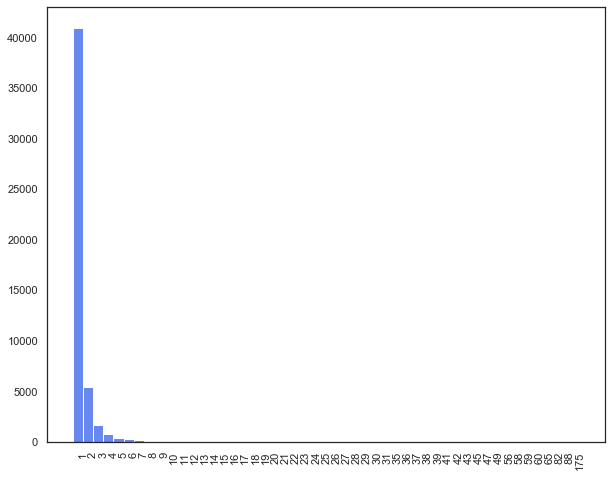

unique posts 0.6914148351648352


In [0]:
# Check how many authors are in both train and test set

X = reddit_data.author.values
y = reddit_data.subreddit.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234)


repeated_posters = Counter(X).values()
histogram(Counter(X).values())

unique_posts = len(np.unique(X))/len(X)
print(f'unique posts {unique_posts}')





In [0]:
# The whole training set 
print(Counter(X).most_common()[:5])
top_poster0 = Counter(X).most_common()[0][0]
top_poster1 = Counter(X).most_common()[1][0]
print(top_poster0)
print([n[:50] for n in reddit_data[reddit_data.author==top_poster0].post.values[:10]])
print(reddit_data[reddit_data.author==top_poster0].subreddit.values[:30])
print([n[:50] for n in reddit_data[reddit_data.author==top_poster1].post.values[:10]])
print(reddit_data[reddit_data.author==top_poster1].subreddit.values[:30])


[('askaboutaa', 175), ('littymcwork', 88), ('jibberjabbery', 82), ('Rhys345', 65), ('EDAnonymous_Bot', 60)]
askaboutaa
['Grapevine Daily Quote April 5 "I  learned ... that', 'Grapevine Daily Quote January 31 "We   well know t', 'Grapevine Daily Quote January 1 "If  humility can ', 'Grapevine Daily Quote December 12 "Coincidences ar', 'Grapevine Daily Quote March 26 "As  AA grows, it i', 'Grapevine Daily Quote February 20 "In  the meeting', 'Grapevine Daily Quote March 28 "One  of the first ', 'Grapevine Daily Quote February 7 "Be willing to be', 'Grapevine Daily Quote March 29 "Until  I was at my', 'Grapevine Daily Quote January 4 "As I trudge the R']
['alcoholism' 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism'
 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism'
 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism'
 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism'
 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism' 'alcoholism'
 'alcoholi

## These are quotes need to be removed. Also would be interesting to see what characterizes people post a lot.  Or in which subreddits are there the most cases of top posters. Do people start posting a lot all of a sudden?


2019 is also from 2018 November?

In [0]:
repeated = [author for author in X_test if author in X_train]
repeated_proportion = len(repeated)/len(X_test)


In [0]:
print(f'repeated_proportion: {repeated_proportion}')

repeated_proportion: 0.4058379120879121


In [0]:
#If we remove top posters, then what is the repeated proportion
repeated_posters = [n for n in Counter(X).most_common() if n[1]>1]
print(f'amount of authors with > 1 post: {len(repeated_posters)/len(X)}')



amount of authors with > 1 post: 0.12847527472527473


In [0]:
# Remove posters > 1
print(reddit_data.shape)
reddit_data_drop_duplicates = reddit_data.drop_duplicates(subset='author', keep='first')
print(reddit_data_drop_duplicates.shape)
reddit_data_drop_duplicates.head()
reddit_data_drop_duplicates.groupby('subreddit').count()



(72800, 351)
(50335, 351)


,author,date,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,gunning_fog_index,lix,...,tfidf_without,tfidf_wonder,tfidf_work,tfidf_world,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
subreddit,,,,,,,,,,,,,,,,,,,,,
EDAnonymous,2945,2945,2945,2945,2945,2945,2945,2945,2945,2945,...,2945,2945,2945,2945,2945,2945,2945,2945,2945,2945
addiction,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,...,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278
adhd,4693,4693,4693,4693,4693,4693,4693,4693,4693,4693,...,4693,4693,4693,4693,4693,4693,4693,4693,4693,4693
alcoholism,3981,3981,3981,3981,3981,3981,3981,3981,3981,3981,...,3981,3981,3981,3981,3981,3981,3981,3981,3981,3981
anxiety,4919,4919,4919,4919,4919,4919,4919,4919,4919,4919,...,4919,4919,4919,4919,4919,4919,4919,4919,4919,4919
autism,3854,3854,3854,3854,3854,3854,3854,3854,3854,3854,...,3854,3854,3854,3854,3854,3854,3854,3854,3854,3854
bipolarreddit,2501,2501,2501,2501,2501,2501,2501,2501,2501,2501,...,2501,2501,2501,2501,2501,2501,2501,2501,2501,2501
depression,4928,4928,4928,4928,4928,4928,4928,4928,4928,4928,...,4928,4928,4928,4928,4928,4928,4928,4928,4928,4928
healthanxiety,2708,2708,2708,2708,2708,2708,2708,2708,2708,2708,...,2708,2708,2708,2708,2708,2708,2708,2708,2708,2708


In [0]:

X = reddit_data_drop_duplicates.author.values
y = reddit_data_drop_duplicates.subreddit.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234)


In [0]:
repeated = [author for author in X_test if author in X_train]
repeated_proportion = len(repeated)/len(X_test)
print(f'repeated_proportion: {repeated_proportion}')

repeated_proportion: 0.0


,subreddit,author,date,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,gunning_fog_index,...,tfidf_without,tfidf_wonder,tfidf_work,tfidf_world,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
5524,EDAnonymous,030728,2018/11/21,Realized I have a crush on a co-worker ... So ...,2.593851,4.392563,4.022119,86.914259,76.152318,6.235558,...,0.000000,0.000000,0.132373,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17181,EDAnonymous,yes_creamcheese,2019/10/18,How I know I'm disordered/PBJ Saga I've been c...,1.388732,3.935638,2.748830,90.178278,85.434109,5.809652,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6894,EDAnonymous,dramanautica,2019/04/27,"Scared I made my sister ED Hey guys, I’m prett...",0.753441,2.579243,2.714194,94.007957,81.903226,5.423656,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
23481,EDAnonymous,SowoneulMalhaebwaa,2019/01/14,Proof that ED makes you think absolutely insan...,4.269207,6.173943,4.917147,81.818512,71.832370,7.717424,...,0.000000,0.000000,0.103792,0.000000,0.000000,0.000000,0.102862,0.000000,0.000000,0.000000
14479,EDAnonymous,whatever171,2019/01/18,"I finally ate real healthily today! 1,200 calo...",1.525446,4.261267,2.817619,87.075000,91.291667,5.242857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19851,EDAnonymous,watchmedisapr,2018/12/21,Off topic: update on my post a week ago Link h...,1.086250,3.167833,2.441971,95.032000,82.184713,4.944108,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.114341
18032,EDAnonymous,throwawayacc19392,2018/12/31,"I am back with an ED... yay, I guess. I gained...",0.978333,2.692428,3.044222,92.473000,80.666667,6.542222,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
28479,EDAnonymous,HockeyPossum,2019/07/20,When you have to quit your job because the mer...,6.804536,5.299578,6.848197,82.180273,65.393443,9.444809,...,0.000000,0.000000,0.179570,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6819,EDAnonymous,whatxever,2019/06/22,EDs + porn :/ navigating my first serious rela...,3.127957,5.295432,4.511442,82.335816,75.789474,7.826850,...,0.053515,0.000000,0.000000,0.000000,0.000000,0.000000,0.078949,0.000000,0.000000,0.075724
22223,EDAnonymous,llaannaa,2019/07/28,Slowly saving money and not having my ED make ...,3.811317,3.760260,6.214064,79.404376,71.123288,9.091629,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076457


## Some preliminary analyses

In [0]:
# Anxiety corona virus
# JAN. 20 Other countries, including the United States, confirmed cases.
"I know this may sound silly, but I\u2019m scared of the coronavirus. A lot of people are saying it\u2019s not a big deal and that I\u2019ll be safe as long as I\u2019m healthy. I know all of this but I\u2019m more scared of the fact that this will turn into a pandemic."

# Other days:
# JAN. 30 The W.H.O. declared a global health emergency
# The World Health Organization on Feb. 11 proposed an official name for the disease the virus coronavirus causes: Covid-19
# Feb 23 Italy sees major surge in coronavirus cases and officials lock down towns.
subreddit = 'healthanxiety'
date_start = '2020/03/24'
date_end = '2020/03/30'

start = date2timestamp(date_start)
end = date2timestamp(date_end)
size = 1000000000
url = 'https://api.pushshift.io/reddit/search/submission/?subreddit={}&sort=desc&sort_type=created_utc&after={}&before={}&size={}'.format(subreddit,start, end, size)
print(url)
# filename = 'scrape_reddit'
# filename = filename+'_{}_{}'.format(date_start.replace('/', ''), date_end.replace('/', ''))


# Comment so it won't download

# url2json(url, output_dir+filename)
# anxiety_covid = json2list(output_dir+filename+'.json')

NameError: name 'date2timestamp' is not defined

In [0]:
timestamp2date(1579395379)

NameError: name 'timestamp2date' is not defined

In [0]:
def scrape_reddit(output_dir, subreddit, timeframe, date_start, date_end, size = 1000):
    '''
    size = {1,1000} #amount of posts
    '''
    start = date2timestamp(date_start)
    end = date2timestamp(date_end)
    url = 'https://api.pushshift.io/reddit/search/submission/?subreddit={}&sort=desc&sort_type=created_utc&after={}&before={}&size={}'.format(subreddit,start, end, size)
    filename = '{}_{}_{}_{}'.format(subreddit, timeframe, date_start.replace('/', ''), date_end.replace('/', ''))
    url2json(url, output_dir+filename)
    posts = json2list(output_dir+filename+'.json')
    posts_filtered = []
    for post in posts:
        post_filtered = {}
        for key in post.keys():
            post_filtered[key]=post.get(key)
        posts_filtered.append(post_filtered)
    # np.savez_compressed(input_dir+filename+'.npz',posts_filtered)
#     os.remove(output_dir+filename+'.json')
    return filename
        


In [ ]:
01/19: 'I’ve been seeing a lot of news stories today about an incurable, lethal disease originating in China spreading to other countries. I know the media often over exaggerates things like this, but WHO is debating whether or not to declare this an international emergency. Nothing triggers my anxiety worse than things like this, if anyone has any advice on how to cope/can inform me on it I would really appreciate it!'


In [0]:
'''
# Early:
01/19: {'created_utc': 1579618862, 'num_comments': 7, 'title': 'The breaking news stories about the coronavirus is making me really nervous and I’m not sure what to do?', 'selftext': 'I’ve been seeing a lot of news stories today about an incurable, lethal disease originating in China spreading to other countries. I know the media often over exaggerates things like this, but WHO is debating whether or not to declare this an international emergency. Nothing triggers my anxiety worse than things like this, if anyone has any advice on how to cope/can inform me on it I would really appreciate it!', 'score': 1},
01/19: {'created_utc': 1579543321, 'num_comments': 1, 'title': 'Wuhan Virus anxiety', 'selftext': "Right off the bat, i'm not chinese or live anywhere in the eastern part of the globe. But i am a massive hypochondriac and terrified of a global outbreak.  \n\n\nThis morning, i saw an article showing a video of airline passengers being screened by medical personal in hazmat suits. With the article spewing the whole sensationalized clickbait crap about an apocalyptic global epidemic.  \n\n\nAnd after seeing it i quickly spiraled into stress and anxiety. Even though i was able to avoid a full on panic attack, this article bothered me to the point that ll i've been thinking about is an outbreak for the rest of the day just by reading a news article for a few minutes.  \n\n\nI hope everybody in the east can stay safe and healthy, the worst i've had today is nearly having a panic attack. Can't imagine how worrying it is over there.", 'score': 1},
01/25: {'created_utc': 1580175419, 'num_comments': 3, 'title': 'so so so scared', 'selftext': 'this corona virus has me absolutely terrified. i know there\'s all these "low mortality" things, but i read to far into the conspiracies and the videos of chinese hospitals and doctors crying for help. \n\nive washed and sanitized my hands to the point they\'re cracked and bleeding. i won\'t leave the house anymore unless its 100% necessary.and even when i do i don\'t touch ANYTHING\n\nim so scared, breaking down crying, i can\'t even eat anymore. nothing the news or cdc says can calm me down because i am fully convinced china is lying and that this could even be a bioweapon. i heard it\'s mutated already and 300,000-1,000,000 people fled china possibly infected. i feel doomed'}



# Suicidality
03/16:        {'created_utc': 1584584727, 'num_comments': 0, 'title': 'I feel like a scared child but I have no parents to run to for safety', 'selftext': "I'm far from being actually alone, I don't even live alone, yet right now with the virus, the economic status, and the high stress everyone is feeling is making me feel like my bones are trying to crawl out of my flesh. I want it to stop, I want to scream and cry, I want to hide and honestly just fucking die so I don't have to live with any of these feelings anymore. I work minimum wage, I'm saving for the house I'm renting in May, but if I lose my job or can't work because of Covid-19 I am absolutely fucked. I am terrified and I feel pinned down by this overwhelming feeling it's all going to get so so much worse...Part of me wishes the world would just end. No worried then. No stress. I'm dreading my state saying we must stay home because my father is bipolar and refuses to go to therapy or get medication so I don't feel safe outside of my room and most of my social interactions outside of work come in arguments with him because he can never be wrong. He has to be right. I wish it would all just freeze or disappear.", 'score': 1},
# Works at hospital
03/16:        {'created_utc': 1584581971, 'num_comments': 0, 'title': 'Feeling overwhelmed about corona and working at the hospital', 'selftext': "I live in New York and work in a hospital. We were short on supplies even before the virus really became a thing here. We don't have masks to give patients. We are not allowed to wear masks ourself. We have been mandated to work and even been told to continue coming to work even if we have had contact with a confirmed positive. We just have to take our temperature daily &amp; we are only to wear a mask if we have active respiratory symptoms.\n\nI have constant shortness of breath and chest pains and pressure due to anxiety which has me constantly stressed. My throat is super dry and idk why. Dry throat and stress leaves you more susceptible to infection in addition to working in a war zone with no protection daily.\n\nI feel so anxious and overwhelmed. I was finally getting my panic attacks sorta under control by going out mor and starting therapy. That's all on hold for the indefinite future. Im constantly afraid of having another panic attack or being in the position where I feel like I'm actually dying and unable to see a provider due to the system being overwhelmed.\n\nThe only positive thing I have going on right now is that its about to be spring and I can garden while social distancing.", 'score': 1},
# Buying guns
03/16:        {'created_utc': 1584581413, 'num_comments': 24, 'title': 'Are we going to all die and go into an apocalypse? The media is starting to freak me out because of the Corona Virus', 'selftext': "I keep on seeing the Corona Virus everywhere now I hear people are buying guns then people are talking about Germany and how bad it is there. I thought that America was handling it very well. And we are on top of it? I'm freaking out. Am I overthinking between all the youtube posts I'm buggin.", 'score': 0},

03/16:        {'created_utc': 1584574890, 'num_comments': 1, 'title': 'My mom is driving herself crazy because of the COVID-19', 'selftext': 'My mom never have suffer from anxiety or other mental illness like OCD, etc. \nSince the COVID-19, we steam and sanitize our house all the day with the steamer machine, we use other product like Clorox or Javex, if she touches something in the house she wash her hand, I suffer from anxiety and it doesn’t help at all! I feel stress will kill our brain before the COVID-19, I’m tired, really tired, I want just this stupid virus to end and to go out. All we do is talking about this virus, the media is not helping at all... my head is gonna explode.', 'score': 3},
# GAD + Isolation  
      {'created_utc': 1584570369, 'num_comments': 0, 'title': 'Being single and living alone is absolutely brutal right now.', 'selftext': 'I live with generalized anxiety disorder and already have major anxiety regarding my health. Had the flu end of January pretty bad and then hives post flu- I’m miserable and was finally getting back on track and then this.\n\n\nI am terrified. Just being alone all day. And can’t see my parents or friends. Or brother. I have been so anxious through all of this for many reasons. \n\nfinally got the work from home okay on Monday but now being told by higher ups where I work (a health science college at a major uni) that someone needs to be in my office during the day, though it’s not essential. I hate the idea of going to my office which is connected to the main hospital in my city.\n\nAnyway. I really could use some people to talk to as I don’t have that many friends and that’s what I need now. I need some more connections and chances to get to other people and distract from the virus.\n\nThanks', 'score': 0},

'''

'\n# Early:\n01/19: {\'created_utc\': 1579618862, \'num_comments\': 7, \'title\': \'The breaking news stories about the coronavirus is making me really nervous and I’m not sure what to do?\', \'selftext\': \'I’ve been seeing a lot of news stories today about an incurable, lethal disease originating in China spreading to other countries. I know the media often over exaggerates things like this, but WHO is debating whether or not to declare this an international emergency. Nothing triggers my anxiety worse than things like this, if anyone has any advice on how to cope/can inform me on it I would really appreciate it!\', \'score\': 1},\n01/19: {\'created_utc\': 1579543321, \'num_comments\': 1, \'title\': \'Wuhan Virus anxiety\', \'selftext\': "Right off the bat, i\'m not chinese or live anywhere in the eastern part of the globe. But i am a massive hypochondriac and terrified of a global outbreak.  \n\n\nThis morning, i saw an article showing a video of airline passengers being screened by